#1.0 Introducción

##1.1 Motivación y Audiencia

###Motivación
El objetivo es mejorar la rentabilidad en cada máquina expendedora. 

Se analizarán los datos para optimizar la oferta de mercadería en cada una de ellas, considerando las preferencias de consumo, la estacionalidad y ubicación. 

En base a los resultados obtenidos, se harán las recomendaciones según el caso para cada ubicación.

###Audiencia
Este análisis pretende aportar datos relevantes para quienes están a cargo de:

* las compras, evitando tener gran cantidad de productos con poca demanda;
* la logística, abasteciendo más eficaz y eficientemente los productos entre las distintas ubicaciones;
* la experiencia del usuario, satisfaciendo las demandas y preferencias de los compradores. 

##1.2 Preguntas de Interés

###Preguntas Principales
* ¿Una mayor variedad de productos en cada máquina implica una mayor recaudación?

* ¿La cantidad de productos vendidos es proporcional a la recaudación?

* ¿Cómo optimizar la oferta según la demanda?

###Preguntas Secundarias (para cada una de las ubicaciones)
* ¿Cuál es la ubicación con más ventas?

* ¿Cuál es la categoría más vendida?

* ¿Cuál es la relación entre los productos más vendidos y la variedad ofrecida?

* ¿Cuál es la relación entre la estacionalidad y la categoría con más ventas?

* ¿Cuál es la relación entre la estacionalidad y las ventas según la ubicación de la máquina?

* ¿Cuál es la relación entre la recaudación y las categorías?¿Y con las ubicaciones?


##1.3 Importación y procesado de datos

In [1]:
#librerias
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
mpl.style.use ('bmh')
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import cufflinks as cf
cf.set_config_file(sharing = 'public',theme='white',offline=True)
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from IPython.display import display,HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [2]:
vending_machines=pd.read_excel('/content/Vending Machines 2.xlsx')
vending_machines = vending_machines.fillna(0)
vending_machines.head()

Status    Device ID           Location               Machine  \
0  Processed  VJ300320611  Brunswick Sq Mall  BSQ Mall x1366 - ATT   
1  Processed  VJ300320611  Brunswick Sq Mall  BSQ Mall x1366 - ATT   
2  Processed  VJ300320611  Brunswick Sq Mall  BSQ Mall x1366 - ATT   
3  Processed  VJ300320611  Brunswick Sq Mall  BSQ Mall x1366 - ATT   
4  Processed  VJ300320611  Brunswick Sq Mall  BSQ Mall x1366 - ATT   

                                Product    Category   Transaction  \
0  Red Bull - Energy Drink - Sugar Free  Carbonated  1.451578e+10   
1  Red Bull - Energy Drink - Sugar Free  Carbonated  1.451602e+10   
2      Takis - Hot Chilli Pepper & Lime        Food  1.451602e+10   
3      Takis - Hot Chilli Pepper & Lime        Food  1.451602e+10   
4  Red Bull - Energy Drink - Sugar Free  Carbonated  1.451602e+10   

             TransDate  Type  RCoil  RPrice  RQty  MCoil  MPrice  MQty  \
0  2022-01-01 00:00:00   1.0  148.0    35.0   1.0  148.0    35.0   1.0   
1  2022-01-01 00:00:00   1.0  148.0    35.0   1.0  148.0    35.0   1.0   
2  2022-01-01 00:00:00   1.0  123.0    15.0   1.0  123.0    15.0   1.0   
3  2022-01-01 00:00:00   1.0  123.0    15.0   1.0  123.0    15.0   1.0   
4  2022-01-01 00:00:00   1.0  148.0    35.0   1.0  148.0    35.0   1.0   

   LineTotal  TransTotal Prcd Date  
0       35.0        35.0  1/1/2022  
1       35.0         5.0  1/1/2022  
2       15.0         5.0  1/1/2022  
3       15.0        15.0  1/1/2022  
4       35.0        35.0  1/1/2022

In [3]:
vending_machines.loc[vending_machines['Location']==0]
vending = vending_machines.drop(1430)
vending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6441 entries, 0 to 6441
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Status       6441 non-null   object 
 1   Device ID    6441 non-null   object 
 2   Location     6441 non-null   object 
 3   Machine      6441 non-null   object 
 4   Product      6441 non-null   object 
 5   Category     6441 non-null   object 
 6   Transaction  6441 non-null   float64
 7   TransDate    6441 non-null   object 
 8   Type         6441 non-null   float64
 9   RCoil        6441 non-null   float64
 10  RPrice       6441 non-null   float64
 11  RQty         6441 non-null   float64
 12  MCoil        6441 non-null   float64
 13  MPrice       6441 non-null   float64
 14  MQty         6441 non-null   float64
 15  LineTotal    6441 non-null   float64
 16  TransTotal   6441 non-null   float64
 17  Prcd Date    6441 non-null   object 
dtypes: float64(10), object(8)
memory usage: 956.1+ K

##1.4 Contexto

In [4]:
#Rango de fechas
vending['TransDate']

0       2022-01-01 00:00:00
1       2022-01-01 00:00:00
2       2022-01-01 00:00:00
3       2022-01-01 00:00:00
4       2022-01-01 00:00:00
               ...         
6437    2022-08-31 00:00:00
6438    2022-08-31 00:00:00
6439    2022-08-31 00:00:00
6440    2022-08-31 00:00:00
6441    2022-08-31 00:00:00
Name: TransDate, Length: 6441, dtype: object

In [5]:
#Ubicaciones
vending['Location'].value_counts()

GuttenPlans          2567
EB Public Library    1919
Brunswick Sq Mall    1279
Earle Asphalt         676
Name: Location, dtype: int64

In [6]:
#Expendedoras
vending['Device ID'].value_counts()

VJ300320609    2567
VJ300320692    1919
VJ300205292     725
VJ300320686     676
VJ300320611     554
Name: Device ID, dtype: int64

In [7]:
#Categorías
vending['Category'].value_counts()

Food              3544
Carbonated        1686
Non Carbonated     728
Water              483
Name: Category, dtype: int64

In [8]:
#Productos
vending['Product'].value_counts()

Coca Cola - Zero Sugar                           517
Monster Energy Original                          385
Poland Springs Water                             300
KitKat - Crisp Wafers                            260
Sunkist Soda - Orange                            217
                                                ... 
Nature's Valley Crunchy Granola Bar - Oats &       1
Nature's Valley Chewy Granola Bar - Fruit & N      1
Zevia Organic Tea - Peach                          1
Nature's Garden Trail Mix - Heart Healthy Mix      1
Quaker Cheddar Rice Crisps                         1
Name: Product, Length: 170, dtype: int64

In [9]:
#Transacciones
vending['TransTotal'].sum()

196798.0

In [10]:
#Recaudación
(vending['RPrice'] * vending['TransTotal']).sum()

24312622.0

### Ubicaciones
**Brunswick Square Mall**

Centro comercial de un solo piso, abierto todos los días de 10 a 20hs; posee dos máquinas expendedoras. 

**Earle Asphalt**

Compañía dedicada a la construcción de caminos y pavimentación para el ámbito público y privado. 

**East Brunswick Public Library**

Biblioteca pública, abierta todos los días de la semana, con diferentes horarios:

Lunes a jueves: 9 a 21hs

Viernes: 9 a 18hs

Sábados: 9 a 17hs

Domingos: 12 a 17hs

**Guttenplan's**

Planta de panificados congelados, funcionando de lunes a viernes, las 24hs.  

#2.0 Análisis Exploratorio de Datos

##2.1 Análisis General

In [19]:
#Creamos un dataset con los atributos que usaremos
data = vending[['TransDate', 'Location', 'Product', 'Category', 'Type', 'LineTotal', 'RQty', 'RPrice','TransTotal']]
data = data.fillna(0)

#Agregamos columna para calcular el dinero recaudado 
data['Money'] = data['RPrice'] * data['TransTotal']
data

TransDate           Location                               Product  \
0    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
1    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
2    2022-01-01  Brunswick Sq Mall      Takis - Hot Chilli Pepper & Lime   
3    2022-01-01  Brunswick Sq Mall      Takis - Hot Chilli Pepper & Lime   
4    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
...         ...                ...                                   ...   
6437 2022-08-31  EB Public Library          Lindens - Chocolate Chippers   
6438 2022-08-31  EB Public Library        Wonderful Pistachios - Variety   
6439 2022-08-31  EB Public Library        Hungry Buddha - Chocolate Chip   
6440 2022-08-31        GuttenPlans                   Snapple Tea - Lemon   
6441 2022-08-31  EB Public Library              Goldfish Baked - Cheddar   

            Category  Type  LineTotal  RQty  RPrice  TransTotal   Money  
0         Carbonated   1.0       35.0   1.0    35.0        35.0  1225.0  
1         Carbonated   1.0       35.0   1.0    35.0         5.0   175.0  
2               Food   1.0       15.0   1.0    15.0         5.0    75.0  
3               Food   1.0       15.0   1.0    15.0        15.0   225.0  
4         Carbonated   1.0       35.0   1.0    35.0        35.0  1225.0  
...              ...   ...        ...   ...     ...         ...     ...  
6437            Food   1.0        2.0   1.0     2.0         6.0    12.0  
6438            Food   1.0        2.0   1.0     2.0         6.0    12.0  
6439            Food   1.0        2.0   1.0     2.0         6.0    12.0  
6440  Non Carbonated   1.0       25.0   1.0    25.0        25.0   625.0  
6441            Food   0.0       15.0   1.0    15.0        15.0   225.0  

[6441 rows x 10 columns]

In [20]:
#Agregamos columna para calcular el dinero recaudado 
data['Money'] = data['RPrice'] * data['TransTotal']
data

TransDate           Location                               Product  \
0    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
1    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
2    2022-01-01  Brunswick Sq Mall      Takis - Hot Chilli Pepper & Lime   
3    2022-01-01  Brunswick Sq Mall      Takis - Hot Chilli Pepper & Lime   
4    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
...         ...                ...                                   ...   
6437 2022-08-31  EB Public Library          Lindens - Chocolate Chippers   
6438 2022-08-31  EB Public Library        Wonderful Pistachios - Variety   
6439 2022-08-31  EB Public Library        Hungry Buddha - Chocolate Chip   
6440 2022-08-31        GuttenPlans                   Snapple Tea - Lemon   
6441 2022-08-31  EB Public Library              Goldfish Baked - Cheddar   

            Category  Type  LineTotal  RQty  RPrice  TransTotal   Money  
0         Carbonated   1.0       35.0   1.0    35.0        35.0  1225.0  
1         Carbonated   1.0       35.0   1.0    35.0         5.0   175.0  
2               Food   1.0       15.0   1.0    15.0         5.0    75.0  
3               Food   1.0       15.0   1.0    15.0        15.0   225.0  
4         Carbonated   1.0       35.0   1.0    35.0        35.0  1225.0  
...              ...   ...        ...   ...     ...         ...     ...  
6437            Food   1.0        2.0   1.0     2.0         6.0    12.0  
6438            Food   1.0        2.0   1.0     2.0         6.0    12.0  
6439            Food   1.0        2.0   1.0     2.0         6.0    12.0  
6440  Non Carbonated   1.0       25.0   1.0    25.0        25.0   625.0  
6441            Food   0.0       15.0   1.0    15.0        15.0   225.0  

[6441 rows x 10 columns]

In [21]:
#Transacciones por ubicación
Trans_total=data[['TransTotal','Location']].groupby(by='Location').sum()
Trans_total

TransTotal
Location                     
Brunswick Sq Mall     48430.0
EB Public Library     81115.0
Earle Asphalt         16939.0
GuttenPlans           50314.0

In [22]:
#Recaudación por ubicación
Money_total=data[['Money','Location']].groupby(by='Location').sum()
Money_total

Money
Location                     
Brunswick Sq Mall   7886617.0
EB Public Library  11715285.0
Earle Asphalt       1404020.0
GuttenPlans         3306700.0

In [23]:
#Productos más caros
Price= data[['Product', 'Category', 'RPrice']]
Price = Price.drop_duplicates()
Price = Price.sort_values('RPrice', ascending = False)
Price

Product        Category  RPrice
1448                     Monster Energy Original      Carbonated   325.0
1336                 Honest Tea - Berry Hibiscus  Non Carbonated   275.0
158       Vitamin Water - Ice Cool Blue Lavender           Water   275.0
286            Vitamin Water - Squeezed Lemonade           Water   275.0
1293           Bai Antioxidant - Kula Watermelon  Non Carbonated   275.0
...                                          ...             ...     ...
1450           Cheetos Flaming Hot Limon Crunchy            Food     1.0
21             Spindrift - Sparkling Water  Lime      Carbonated     1.0
1183         Starbucks Doubleshot Energy - Mocha  Non Carbonated     1.0
1446                Doritos Dinamita Chile Lemon            Food     1.0
33    Pure Organic Fruit Bar - Strawberry Banana            Food     1.0

[238 rows x 3 columns]

In [24]:
#Productos vendidos por categoría
cat = data[['Category', 'TransTotal']].groupby('Category').sum()
cat

TransTotal
Category                  
Carbonated         34310.0
Food               92427.0
Non Carbonated     41002.0
Water              29059.0

In [25]:
#Dinero recaudado por categoría
Money_cat = data[['Category', 'Money']].groupby('Category').sum()
Money_cat

Money
Category                 
Carbonated      3820417.0
Food            6286783.0
Non Carbonated  7546106.0
Water           6659316.0

In [26]:
#Productos ofrecidos por ubicación, por categoría
df_cantprod2 = data[['Product', 'Location', 'Category']]
df_cantprod2 = df_cantprod2.drop_duplicates()

#Productos ofrecidos por EA, por categoría
df_cantprodEA = df_cantprod2 [df_cantprod2['Location'] == 'Earle Asphalt']
df_cantprodEA = df_cantprodEA.drop(['Location'], axis = 'columns')
df_cantprodEA = df_cantprodEA.drop_duplicates()
df_cantprodEA = df_cantprodEA.groupby('Category').count()
df_cantprodEA = df_cantprodEA.rename({'Product': 'Earle Asphalt'}, axis = 1)

#Productos ofrecidos por BM, por categoría
df_cantprodBM = df_cantprod2 [df_cantprod2['Location'] == 'Brunswick Sq Mall']
df_cantprodBM = df_cantprodBM.drop(['Location'], axis = 'columns')
df_cantprodBM = df_cantprodBM.drop_duplicates()
df_cantprodBM = df_cantprodBM.groupby('Category').count()
df_cantprodBM = df_cantprodBM.rename({'Product': 'Brunswick Sq Mall'}, axis = 1)

#Productos ofrecidos por EB, por categoría
df_cantprodEB = df_cantprod2 [df_cantprod2['Location'] == 'EB Public Library']
df_cantprodEB = df_cantprodEB.drop(['Location'], axis = 'columns')
df_cantprodEB = df_cantprodEB.drop_duplicates()
df_cantprodEB = df_cantprodEB.groupby('Category').count()
df_cantprodEB = df_cantprodEB.rename({'Product': 'EB Public Library'}, axis = 1)

#Productos ofrecidos por GP, por categoría
df_cantprodGP = df_cantprod2 [df_cantprod2['Location'] == 'GuttenPlans']
df_cantprodGP = df_cantprodGP.drop(['Location'], axis = 'columns')
df_cantprodGP = df_cantprodGP.drop_duplicates()
df_cantprodGP = df_cantprodGP.groupby('Category').count()
df_cantprodGP = df_cantprodGP.rename({'Product': 'GuttenPlans'}, axis = 1)

#Productos ofrecidos por ubicación, por categoría
df_cantprod = df_cantprodEA.merge(df_cantprodBM, on = 'Category', how = 'left').merge(df_cantprodEB, on = 'Category', how = 'left').merge(df_cantprodGP, on = 'Category', how = 'left')
df_cantprod = df_cantprod.fillna(0)
df_cantprod = df_cantprod.transpose()
df_cantprod.rename(columns = {'Non Carbonated': 'NonCarbonated'}, inplace = True)
df_cantprod

Category           Carbonated  Food  NonCarbonated  Water
Earle Asphalt             6.0  42.0            4.0    4.0
Brunswick Sq Mall        14.0  53.0           15.0   10.0
EB Public Library         8.0  61.0           15.0    4.0
GuttenPlans               6.0  58.0            8.0    0.0

In [27]:
#Categoría por mes
Mensual = data[['TransDate', 'Product', 'Category', 'TransTotal']]
Mensual['TransMonth'] = pd.DatetimeIndex(Mensual['TransDate']).month
Mensual_cat = pd.DataFrame()
Mensual_cat = Mensual.pivot_table(index = 'Category', columns = 'TransMonth', values = 'TransTotal', aggfunc = 'sum')
Mensual_cat = Mensual_cat.fillna(0)
Mensual_cat = Mensual_cat.transpose()
Mensual_cat

Category    Carbonated     Food  Non Carbonated   Water
TransMonth                                             
1                576.0   5852.0          1195.0  1241.0
2               1552.0   5147.0          1303.0  1036.0
3               2500.0  12217.0          3991.0  3440.0
4               8078.0  11052.0          6323.0  3092.0
5               5705.0  12435.0          4650.0  5310.0
6               5451.0  17939.0          8434.0  3291.0
7               7535.0  15310.0          7814.0  7033.0
8               2913.0  12475.0          7292.0  4616.0

In [28]:
#Categoría por mes
Mensual_cat2 = Mensual_cat
Mensual_cat2['Tot'] = Mensual_cat2['Carbonated'] + Mensual_cat2['Food'] + Mensual_cat2['Non Carbonated'] + Mensual_cat2['Water']
Mensual_cat2

Category    Carbonated     Food  Non Carbonated   Water      Tot
TransMonth                                                      
1                576.0   5852.0          1195.0  1241.0   8864.0
2               1552.0   5147.0          1303.0  1036.0   9038.0
3               2500.0  12217.0          3991.0  3440.0  22148.0
4               8078.0  11052.0          6323.0  3092.0  28545.0
5               5705.0  12435.0          4650.0  5310.0  28100.0
6               5451.0  17939.0          8434.0  3291.0  35115.0
7               7535.0  15310.0          7814.0  7033.0  37692.0
8               2913.0  12475.0          7292.0  4616.0  27296.0

In [29]:
#Productos más vendidos
mas_vend = data [['Product', 'TransTotal']].groupby('Product').sum()
mas_vend = mas_vend.sort_values('TransTotal', ascending = False)
mas_vend

TransTotal
Product                                                  
CheezIt - Original                                11499.0
Goldfish Baked - Cheddar                          10494.0
BodyArmor LYTE - Strawberry Lemonade               9575.0
Bai Antioxidant - Tanzania Lemon Super Tea         9425.0
KitKat - Crisp Wafers                              7381.0
...                                                   ...
Stretch Island Fruit Leathers Snacks - Variet         7.0
Remedy Kombucha - Ginger Lemon                        6.0
Made in Nature - Mangoes Sweet & Tangy                6.0
Pure Organic Pineapple Passionfruit                   5.0
Larabar - Peanut Butter chocolate Chip                2.0

[170 rows x 1 columns]

In [30]:
#Productos más vendidos indicando categoría
mas_vend2 = mas_vend.merge(df_cantprod2, on = 'Product', how = 'left' )
mas_vend2 = mas_vend2.drop(['Location'], axis = 'columns')
mas_vend2 = mas_vend2.drop_duplicates()
mas_vend2

Product  TransTotal        Category
0                               CheezIt - Original     11499.0            Food
4                         Goldfish Baked - Cheddar     10494.0            Food
7             BodyArmor LYTE - Strawberry Lemonade      9575.0           Water
9       Bai Antioxidant - Tanzania Lemon Super Tea      9425.0  Non Carbonated
10                           KitKat - Crisp Wafers      7381.0            Food
..                                             ...         ...             ...
303  Stretch Island Fruit Leathers Snacks - Variet         7.0            Food
304                 Remedy Kombucha - Ginger Lemon         6.0      Carbonated
305         Made in Nature - Mangoes Sweet & Tangy         6.0            Food
306            Pure Organic Pineapple Passionfruit         5.0            Food
307         Larabar - Peanut Butter chocolate Chip         2.0            Food

[170 rows x 3 columns]

In [31]:
mas_vend.nsmallest(42, 'TransTotal')

TransTotal
Product                                                  
Larabar - Peanut Butter chocolate Chip                2.0
Pure Organic Pineapple Passionfruit                   5.0
Remedy Kombucha - Ginger Lemon                        6.0
Made in Nature - Mangoes Sweet & Tangy                6.0
Stretch Island Fruit Leathers Snacks - Variet         7.0
Pure Organic Fruit Bar - Raspberry Lemonade           9.0
NuGo Dark Chocolate - Pretzel Sea Salt               12.0
Monster Energy  Zero Ultra                           12.0
Nature's Garden Trail Mix - Heart Healthy Mix        15.0
Belvita Snack Bites - Cinnamon BS Go Paks            15.0
Nature's Garden Trail Mix - Omega 3                  15.0
NuGo Dark Chocolate - Choc Chip                      18.0
Zevia Organic Tea - Peach                            25.0
Hungry Buddha - Chocolate Chip                       26.0
Belvita Breakfast Biscuit Bites - Blueberry          30.0
Spindrift - Sparkling Water Raspberry Lime           30.0
Quaker Cheddar Rice Crisps                           35.0
RXBAR - Protein Bar - Chocolate Sea Salt             38.0
Keto Bar - Chocolate Dream                           39.0
Autumns Granola Bar - Cinnamon Almond                40.0
Zone Perfect - Chocolate Chip Cookie Dough           43.0
Nutter Butter Bites                                  43.0
Belvita Breakfast Cookies - Blueberry                45.0
Hungry Buddha - Coconut Cocoa                        45.0
Lays Baked - Barbecue                                45.0
Bubly - Grapefruit                                   45.0
Bubly - Lime                                         48.0
BodyArmor LYTE  - Berry Punch                        50.0
Ice Breakers Ice Cubes - PepperMint                  50.0
TruBar - Daydreaming about Donuts                    50.0
Quaker ButterMilk Ranch Rice Crisps                  52.0
Keep Healthy - Chocolate Fudge                       53.0
CheezIt - Go Paks                                    54.0
Bubly - Blackberry                                   60.0
KIND Bar - Dark Choc Almond SeaSalt                  60.0
Oberto Specialty Meats - Original                    65.0
RXBAR - Protein Bar - Peanut Butter                  70.0
Quaker Apple Cinnamon Rice Crisps                    72.0
Bubly - Mango                                        75.0
S. Pellegrino Essenza Mineral Water - Blood O        75.0
Bubly - Cherry                                       75.0
Quaker Caramel Rice Crisps                           75.0

##2.2 Análisis para Earle Asphalt

In [32]:
#Earle Asphalt 
EA = data[data['Location']== 'Earle Asphalt']
EA

TransDate       Location                                        Product  \
7    2022-01-03  Earle Asphalt  Miss Vickie's Potato Chip - Lime & Cracked Pe   
9    2022-01-03  Earle Asphalt    Seapoint Farms Dry Roasted Edamame - Wasabi   
13   2022-01-03  Earle Asphalt                          KitKat - Crisp Wafers   
15   2022-01-03  Earle Asphalt                 Wonderful Pistachios - Variety   
16   2022-01-03  Earle Asphalt                 Wonderful Pistachios - Variety   
...         ...            ...                                            ...   
6432 2022-08-31  Earle Asphalt                   Lindens - Chocolate Chippers   
6433 2022-08-31  Earle Asphalt                    SunChips Multigrain - Salsa   
6434 2022-08-31  Earle Asphalt      Keto Bar - Creamy Peanut Butter Chocolate   
6435 2022-08-31  Earle Asphalt                 Wonderful Pistachios - Variety   
6436 2022-08-31  Earle Asphalt  Robert Irvine's - Fit Crunch -  Chocolate Pea   

     Category  Type  LineTotal  RQty  RPrice  TransTotal    Money  
7        Food   1.0       15.0   1.0    15.0        15.0    225.0  
9        Food   1.0       25.0   1.0    25.0        25.0    625.0  
13       Food   1.0      175.0   1.0   175.0       175.0  30625.0  
15       Food   0.0        2.0   1.0     2.0         2.0      4.0  
16       Food   0.0        2.0   1.0     2.0         2.0      4.0  
...       ...   ...        ...   ...     ...         ...      ...  
6432     Food   1.0      225.0   1.0   225.0       225.0  50625.0  
6433     Food   0.0       15.0   1.0    15.0        15.0    225.0  
6434     Food   0.0        2.0   1.0     2.0         2.0      4.0  
6435     Food   0.0        2.0   1.0     2.0         2.0      4.0  
6436     Food   0.0        2.0   1.0     2.0         2.0      4.0  

[676 rows x 10 columns]

In [33]:
#Categoría más vendida
EA_Category = EA[['TransTotal', 'Category']].groupby(by='Category').sum()
EA_Category

TransTotal
Category                  
Carbonated           355.0
Food               15675.0
Non Carbonated       598.0
Water                311.0

In [34]:
#Producto más vendido 
EA_Product = EA[['Product','TransTotal']].groupby(by='Product').sum()
EA_Product = EA_Product.sort_values('TransTotal', ascending = False)
EA_Product

TransTotal
Product                                                  
CheezIt - Original                                 2852.0
KitKat - Crisp Wafers                              2650.0
Goldfish Baked - Cheddar                           1400.0
Takis - Hot Chilli Pepper & Lime                    980.0
Wonderful Pistachios - Variety                      831.0
Belvita Snack Packs - Blueberry                     775.0
Miss Vickie's Potato Chip - Smokehouse BBQ          498.0
SunChips Multigrain - Harvest Cheddar               491.0
Miss Vickie's Potato Chip - Jalapeno                465.0
Snapple Diet Tea - Lemon                            458.0
Lindens - Chocolate Chippers                        450.0
SunChips Multigrain - Salsa                         420.0
Kinder - Bueno - Crispy Creamy Chocolate            391.0
Pop Corners - Sea Salt                              383.0
Jacks Links Bar Beef Strip                          371.0
Oreo Mini                                           276.0
Belvita Snack Packs - Cinnamon                      250.0
Robert Irvine's - Fit Crunch -  Chocolate Pea       244.0
Miss Vickie's Potato Chip - Lime & Cracked Pe       240.0
Good Health Veggie Stix - Sea Salt                  195.0
Miss Vickie's Potato Chip - Sea Salt & Vinega       183.0
CheezIt - Cheddar Sour Cream and Onion              168.0
Coca Cola - Zero Sugar                              150.0
Pop Corners - Kettle Corn                           131.0
Newtons Fig Bar                                     130.0
Seapoint Farms Dry Roasted Edamame - Wasabi         125.0
Snyder's of Hanover Pretzel - Cheddar Cheese        120.0
CheezIt - Double Cheese                             120.0
SunChips Multigrain - Original                      105.0
Vitamin Water - Ice Cool Blue Lavender              100.0
Vitamin Water - Squeezed Lemonade                   100.0
V8 Vegetable Juice - Original                        90.0
S. Pellegrino Essenza Mineral Water - Blood O        75.0
Pop Corners - White Cheddar                          75.0
Spindrift - Sparkling Water  Lime                    70.0
BodyArmor LYTE  - Peach Mango                        61.0
Pop Corners - Spicy Queso                            60.0
BodyArmor LYTE  - Berry Punch                        50.0
Belvita Breakfast Cookies - Blueberry                45.0
CheezIt - White Cheddar                              45.0
Keto Bar - Chocolate Dream                           35.0
Keto Krisp - Almond Butter                           32.0
Good Health Veggie Stix - Zesty Ranch                30.0
Cheetos Baked - Flaming Hot                          30.0
Zevia Organic Tea - Peach                            25.0
Snapple Diet Tea - Raspberry                         25.0
Keto Bar - Creamy Peanut Butter Chocolate            22.0
RXBAR - Protein Bar - Peanut Butter                  20.0
NuGo Dark Chocolate - Choc Chip                      18.0
Keto Krisp - Almond/Chocolate                        16.0
Popchips Potato - Barbeque                           15.0
Oreo Single Server 6 ct                              12.0
Monster Energy  Zero Ultra                           12.0
Hungry Buddha - Chocolate Chip                       10.0
RXBAR - Protein Bar - Chocolate Sea Salt              8.0
Made in Nature - Mangoes Sweet & Tangy                6.0

In [35]:
#Top 5 productos más vendidos
EA_Product.nlargest(5, 'TransTotal')

TransTotal
Product                                     
CheezIt - Original                    2852.0
KitKat - Crisp Wafers                 2650.0
Goldfish Baked - Cheddar              1400.0
Takis - Hot Chilli Pepper & Lime       980.0
Wonderful Pistachios - Variety         831.0

In [36]:
#Top 5 productos menos vendidos
EA_Product.nsmallest(5, 'TransTotal')

TransTotal
Product                                             
Made in Nature - Mangoes Sweet & Tangy           6.0
RXBAR - Protein Bar - Chocolate Sea Salt         8.0
Hungry Buddha - Chocolate Chip                  10.0
Oreo Single Server 6 ct                         12.0
Monster Energy  Zero Ultra                      12.0

In [37]:
#Productos que en promedio se vendieron mensualmente 5 o menos
EA_menos = EA_Product.loc[EA_Product['TransTotal'] <=40]
EA_menos = EA_menos.sort_values('TransTotal')
EA_menos

TransTotal
Product                                              
Made in Nature - Mangoes Sweet & Tangy            6.0
RXBAR - Protein Bar - Chocolate Sea Salt          8.0
Hungry Buddha - Chocolate Chip                   10.0
Oreo Single Server 6 ct                          12.0
Monster Energy  Zero Ultra                       12.0
Popchips Potato - Barbeque                       15.0
Keto Krisp - Almond/Chocolate                    16.0
NuGo Dark Chocolate - Choc Chip                  18.0
RXBAR - Protein Bar - Peanut Butter              20.0
Keto Bar - Creamy Peanut Butter Chocolate        22.0
Zevia Organic Tea - Peach                        25.0
Snapple Diet Tea - Raspberry                     25.0
Good Health Veggie Stix - Zesty Ranch            30.0
Cheetos Baked - Flaming Hot                      30.0
Keto Krisp - Almond Butter                       32.0
Keto Bar - Chocolate Dream                       35.0

In [38]:
#Productos ofrecidos por categoría
EA_Product2 = EA[['Product', 'Category', 'TransTotal']]
EA_Product2 = EA_Product2.drop_duplicates()
EA_Product2

Product        Category  \
7     Miss Vickie's Potato Chip - Lime & Cracked Pe            Food   
9       Seapoint Farms Dry Roasted Edamame - Wasabi            Food   
13                            KitKat - Crisp Wafers            Food   
15                   Wonderful Pistachios - Variety            Food   
39    Robert Irvine's - Fit Crunch -  Chocolate Pea            Food   
...                                             ...             ...   
5959                 Wonderful Pistachios - Variety            Food   
5960                      Pop Corners - Kettle Corn            Food   
6053                      Zevia Organic Tea - Peach  Non Carbonated   
6157                     Keto Bar - Chocolate Dream            Food   
6393                   Lindens - Chocolate Chippers            Food   

      TransTotal  
7           15.0  
9           25.0  
13         175.0  
15           2.0  
39           2.0  
...          ...  
5959        35.0  
5960        35.0  
6053        25.0  
6157        35.0  
6393       225.0  

[85 rows x 3 columns]

In [39]:
#Categoría por mes
EA['TransMonth'] = pd.DatetimeIndex(EA['TransDate']).month
EA_Category_Month = pd.DataFrame()
EA_Category_Month = EA.pivot_table(index='TransMonth', columns='Category', values='TransTotal', aggfunc='sum')
EA_Category_Month = EA_Category_Month.fillna(0)
EA_Category_Month 

Category    Carbonated    Food  Non Carbonated  Water
TransMonth                                           
1                 30.0  1237.0           220.0   54.0
2                135.0  1967.0           155.0  157.0
3                  4.0  2211.0           129.0   50.0
4                  0.0  2461.0            29.0    0.0
5                 15.0  1152.0             0.0   25.0
6                  3.0  1101.0             0.0    0.0
7                 73.0  1952.0            25.0    0.0
8                 95.0  3594.0            40.0   25.0

In [40]:
#Producto por mes
EA['TransMonth'] = pd.DatetimeIndex(EA['TransDate']).month
EA_Product_Month = pd.DataFrame()
EA_Product_Month = EA.pivot_table(index='Product', columns='TransMonth', values='TransTotal', aggfunc='sum')
EA_Product_Month = EA_Product_Month.fillna(0)
EA_Product_Month 

TransMonth                                         1      2      3       4  \
Product                                                                      
Belvita Breakfast Cookies - Blueberry           30.0   15.0    0.0     0.0   
Belvita Snack Packs - Blueberry                  0.0  400.0  125.0   250.0   
Belvita Snack Packs - Cinnamon                   0.0    0.0  125.0     0.0   
BodyArmor LYTE  - Berry Punch                   25.0    0.0    0.0     0.0   
BodyArmor LYTE  - Peach Mango                    4.0   57.0    0.0     0.0   
Cheetos Baked - Flaming Hot                     30.0    0.0    0.0     0.0   
CheezIt - Cheddar Sour Cream and Onion           0.0    0.0    0.0     0.0   
CheezIt - Double Cheese                          0.0    0.0    0.0     0.0   
CheezIt - Original                             375.0  750.0  325.0  1150.0   
CheezIt - White Cheddar                          0.0    0.0    0.0     0.0   
Coca Cola - Zero Sugar                           0.0   45.0    0.0     0.0   
Goldfish Baked - Cheddar                         0.0    0.0    0.0     0.0   
Good Health Veggie Stix - Sea Salt              45.0  150.0    0.0     0.0   
Good Health Veggie Stix - Zesty Ranch            0.0   30.0    0.0     0.0   
Hungry Buddha - Chocolate Chip                   0.0    0.0    0.0     0.0   
Jacks Links Bar Beef Strip                       0.0    0.0  347.0    24.0   
Keto Bar - Chocolate Dream                       0.0    0.0    0.0     0.0   
Keto Bar - Creamy Peanut Butter Chocolate        0.0    0.0    0.0     0.0   
Keto Krisp - Almond Butter                       8.0   20.0    4.0     0.0   
Keto Krisp - Almond/Chocolate                   16.0    0.0    0.0     0.0   
Kinder - Bueno - Crispy Creamy Chocolate         0.0    2.0    2.0     2.0   
KitKat - Crisp Wafers                          175.0    0.0    0.0     0.0   
Lindens - Chocolate Chippers                     0.0    0.0    0.0     0.0   
Made in Nature - Mangoes Sweet & Tangy           0.0    0.0    2.0     0.0   
Miss Vickie's Potato Chip - Jalapeno            75.0    0.0  135.0    60.0   
Miss Vickie's Potato Chip - Lime & Cracked Pe   90.0  120.0   15.0     0.0   
Miss Vickie's Potato Chip - Sea Salt & Vinega    0.0    0.0   15.0    60.0   
Miss Vickie's Potato Chip - Smokehouse BBQ      30.0  120.0   93.0    60.0   
Monster Energy  Zero Ultra                       6.0    0.0    0.0     0.0   
Newtons Fig Bar                                  0.0    0.0    0.0     0.0   
NuGo Dark Chocolate - Choc Chip                  4.0   10.0    4.0     0.0   
Oreo Mini                                        0.0    0.0    0.0     0.0   
Oreo Single Server 6 ct                          0.0    0.0    0.0     0.0   
Pop Corners - Kettle Corn                        0.0    0.0    0.0     0.0   
Pop Corners - Sea Salt                           0.0    0.0    0.0     0.0   
Pop Corners - Spicy Queso                        0.0    0.0    0.0     0.0   
Pop Corners - White Cheddar                      0.0    0.0    0.0     0.0   
Popchips Potato - Barbeque                      15.0    0.0    0.0     0.0   
RXBAR - Protein Bar - Chocolate Sea Salt         0.0    0.0    2.0     0.0   
RXBAR - Protein Bar - Peanut Butter              0.0    0.0    2.0     0.0   
Robert Irvine's - Fit Crunch -  Chocolate Pea   24.0   67.0   28.0    18.0   
S. Pellegrino Essenza Mineral Water - Blood O    0.0    0.0    0.0     0.0   
Seapoint Farms Dry Roasted Edamame - Wasabi     75.0    0.0   25.0     0.0   
Snapple Diet Tea - Lemon                       175.0  125.0  129.0    29.0   
Snapple Diet Tea - Raspberry                     0.0    0.0    0.0     0.0   
Snyder's of Hanover Pretzel - Cheddar Cheese    45.0   75.0    0.0     0.0   
Spindrift - Sparkling Water  Lime                0.0   70.0    0.0     0.0   
SunChips Multigrain - Harvest Cheddar          105.0    0.0  127.0   154.0   
SunChips Multigrain - Original                   0.0    0.0    0.0     0.0   
SunChips Multigrain - 

##2.3 Análisis para Brunswick Sq Mall

In [41]:
#Brunswick Sq Mall
BM = data[data['Location']== 'Brunswick Sq Mall']
BM

TransDate           Location                               Product  \
0    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
1    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
2    2022-01-01  Brunswick Sq Mall      Takis - Hot Chilli Pepper & Lime   
3    2022-01-01  Brunswick Sq Mall      Takis - Hot Chilli Pepper & Lime   
4    2022-01-01  Brunswick Sq Mall  Red Bull - Energy Drink - Sugar Free   
...         ...                ...                                   ...   
6404 2022-08-30  Brunswick Sq Mall    Pop Corners - Sweet & Salty Kettle   
6405 2022-08-30  Brunswick Sq Mall    Pop Corners - Sweet & Salty Kettle   
6420 2022-08-30  Brunswick Sq Mall                  Poland Springs Water   
6428 2022-08-30  Brunswick Sq Mall     Canada Dry - Ginger Ale & Lemonde   
6430 2022-08-30  Brunswick Sq Mall                   Snapple Tea - Lemon   

            Category  Type  LineTotal  RQty  RPrice  TransTotal   Money  
0         Carbonated   1.0       35.0   1.0    35.0        35.0  1225.0  
1         Carbonated   1.0       35.0   1.0    35.0         5.0   175.0  
2               Food   1.0       15.0   1.0    15.0         5.0    75.0  
3               Food   1.0       15.0   1.0    15.0        15.0   225.0  
4         Carbonated   1.0       35.0   1.0    35.0        35.0  1225.0  
...              ...   ...        ...   ...     ...         ...     ...  
6404            Food   0.0       15.0   1.0    15.0        15.0   225.0  
6405            Food   0.0       15.0   1.0    15.0        15.0   225.0  
6420           Water   1.0        2.0   1.0     2.0         2.0     4.0  
6428      Carbonated   0.0       15.0   1.0    15.0        15.0   225.0  
6430  Non Carbonated   1.0       25.0   1.0    25.0        25.0   625.0  

[1279 rows x 10 columns]

In [42]:
#Categoría más vendida
BM_Category = BM[['TransTotal','Category']].groupby(by='Category').sum()
BM_Category

TransTotal
Category                  
Carbonated          8372.0
Food               13403.0
Non Carbonated      8650.0
Water              18005.0

In [43]:
#Producto más vendido 
BM_Product = BM[['Product', 'TransTotal']].groupby(by='Product').sum()
BM_Product = BM_Product.sort_values('TransTotal', ascending = False)
BM_Product

TransTotal
Product                                            
Vitamin Water - Squeezed Lemonade            5504.0
Vitamin Water - XXX Acai BB Pomegranate      4675.0
Canada Dry - Ginger Ale                      4002.0
CheezIt - Original                           2550.0
BodyArmor LYTE  - Peach Mango                2475.0
...                                             ...
NuGo Dark Chocolate - Pretzel Sea Salt         12.0
RXBAR - Protein Bar - Peanut Butter             8.0
Autumns Granola Bar - Cinnamon Almond           6.0
Keto Bar - Chocolate Dream                      4.0
Larabar - Peanut Butter chocolate Chip          2.0

[92 rows x 1 columns]

In [44]:
#Top 5 productos más vendidos
BM_Product.nlargest(5, 'TransTotal')

TransTotal
Product                                            
Vitamin Water - Squeezed Lemonade            5504.0
Vitamin Water - XXX Acai BB Pomegranate      4675.0
Canada Dry - Ginger Ale                      4002.0
CheezIt - Original                           2550.0
BodyArmor LYTE  - Peach Mango                2475.0

In [45]:
#Top 5 productos menos vendidos
BM_Product.nsmallest(5, 'TransTotal')

TransTotal
Product                                           
Larabar - Peanut Butter chocolate Chip         2.0
Keto Bar - Chocolate Dream                     4.0
Autumns Granola Bar - Cinnamon Almond          6.0
RXBAR - Protein Bar - Peanut Butter            8.0
NuGo Dark Chocolate - Pretzel Sea Salt        12.0

In [46]:
#Productos que en promedio se vendieron mensualmente cinco o menos
BM_menos = BM_Product.loc[BM_Product['TransTotal'] <=40]
BM_menos = BM_menos.sort_values('TransTotal')
BM_menos

TransTotal
Product                                                  
Larabar - Peanut Butter chocolate Chip                2.0
Keto Bar - Chocolate Dream                            4.0
Autumns Granola Bar - Cinnamon Almond                 6.0
RXBAR - Protein Bar - Peanut Butter                   8.0
NuGo Dark Chocolate - Pretzel Sea Salt               12.0
SunChips Multigrain - French Onion                   15.0
Nature's Garden Trail Mix - Heart Healthy Mix        15.0
Nature's Garden Trail Mix - Omega 3                  15.0
RXBAR - Protein Bar - Chocolate Sea Salt             16.0
Snyder's of Hanover Pretzel - Cheddar Cheese         18.0
Coca Cola - Regular                                  20.0
Belvita Breakfast Biscuit Bites - Blueberry          30.0
Popchips Potato - Barbeque                           30.0
Spindrift - Sparkling Water Raspberry Lime           30.0
Miss Vickie's Potato Chip - Jalapeno                 30.0
Keto Bar - Creamy Peanut Butter Chocolate            33.0

In [47]:
#Productos ofrecidos por categoría
BM_Product2 = BM[['Product', 'Category', 'TransTotal']]
BM_Product2 = BM_Product2.drop_duplicates()
BM_Product2

Product        Category  \
0              Red Bull - Energy Drink - Sugar Free      Carbonated   
1              Red Bull - Energy Drink - Sugar Free      Carbonated   
2                  Takis - Hot Chilli Pepper & Lime            Food   
3                  Takis - Hot Chilli Pepper & Lime            Food   
5                     Bai Antioxidant - Brasilia BB  Non Carbonated   
...                                             ...             ...   
6335  Robert Irvine's - Fit Crunch -  Chocolate Pea            Food   
6343                     Popchips Potato - Sea Salt            Food   
6344                                      Oreo Mini            Food   
6386                            Snapple Tea - Lemon  Non Carbonated   
6387                         Coca Cola - Zero Sugar      Carbonated   

      TransTotal  
0           35.0  
1            5.0  
2            5.0  
3           15.0  
5           25.0  
...          ...  
6335         6.0  
6343         3.0  
6344         3.0  
6386         6.0  
6387         6.0  

[195 rows x 3 columns]

In [48]:
#Categoría por mes
BM['TransMonth'] = pd.DatetimeIndex(BM['TransDate']).month
BM_Category_Month = pd.DataFrame()
BM_Category_Month = BM.pivot_table(index='TransMonth', columns='Category', values='TransTotal', aggfunc='sum')
BM_Category_Month = BM_Category_Month.fillna(0)
BM_Category_Month 

Category    Carbonated    Food  Non Carbonated   Water
TransMonth                                            
1                338.0  1180.0           530.0  1187.0
2               1145.0  1624.0           604.0   879.0
3                294.0  1975.0           304.0  3375.0
4                355.0   903.0           204.0  2464.0
5                643.0  1953.0           681.0  4745.0
6               2017.0  1871.0          2917.0   941.0
7               3365.0  2987.0          2644.0  3082.0
8                215.0   910.0           766.0  1332.0

In [49]:
#Producto por mes
BM['TransMonth'] = pd.DatetimeIndex(BM['TransDate']).month
BM_Product_Month = pd.DataFrame()
BM_Product_Month = BM.pivot_table(index='Product', columns='TransMonth', values='TransTotal', aggfunc='sum')
BM_Product_Month = BM_Product_Month.fillna(0)
BM_Product_Month 

TransMonth                                    1      2       3       4  \
Product                                                                  
Autumns Granola Bar - Cinnamon Almond       0.0    0.0     2.0     0.0   
Bai Antioxidant - Brasilia BB              50.0    0.0    50.0     0.0   
Bai Antioxidant - Kupang strawberry kiwi    0.0    0.0     0.0     0.0   
Bai Antioxidant - Molokai Coconut          50.0  129.0    50.0     0.0   
Bai Antioxidant - Zambia Bingcherry       130.0  100.0     0.0     0.0   
...                                         ...    ...     ...     ...   
Vitamin Water - Ice Cool Blue Lavender     55.0    0.0   825.0   275.0   
Vitamin Water - Squeezed Lemonade         550.0  550.0  2204.0  1100.0   
Vitamin Water - XXX Acai BB Pomegranate   275.0    0.0     0.0   550.0   
Wonderful Pistachios - Variety              0.0  329.0     0.0     2.0   
Zevia Zero Calorie Energy - Mango Ginger   25.0   50.0     0.0     0.0   

TransMonth                                     5       6       7     8  
Product                                                                 
Autumns Granola Bar - Cinnamon Almond        2.0     0.0     2.0   0.0  
Bai Antioxidant - Brasilia BB                0.0     0.0     0.0   0.0  
Bai Antioxidant - Kupang strawberry kiwi     0.0  1430.0   550.0   0.0  
Bai Antioxidant - Molokai Coconut           50.0     0.0     0.0   0.0  
Bai Antioxidant - Zambia Bingcherry          0.0     0.0     0.0   0.0  
...                                          ...     ...     ...   ...  
Vitamin Water - Ice Cool Blue Lavender     275.0     0.0     0.0   0.0  
Vitamin Water - Squeezed Lemonade         1100.0     0.0     0.0   0.0  
Vitamin Water - XXX Acai BB Pomegranate   1925.0   550.0  1375.0   0.0  
Wonderful Pistachios - Variety               4.0    10.0     9.0  14.0  
Zevia Zero Calorie Energy - Mango Ginger     0.0    50.0     0.0  25.0  

[92 rows x 8 columns]

##2.4 Análisis para EB Public Library

In [50]:
#EB Public Library
EB = data[data['Location']== 'EB Public Library']
EB

TransDate           Location  \
1183 2022-03-14  EB Public Library   
1186 2022-03-14  EB Public Library   
1202 2022-03-15  EB Public Library   
1207 2022-03-15  EB Public Library   
1211 2022-03-15  EB Public Library   
...         ...                ...   
6427 2022-08-30  EB Public Library   
6437 2022-08-31  EB Public Library   
6438 2022-08-31  EB Public Library   
6439 2022-08-31  EB Public Library   
6441 2022-08-31  EB Public Library   

                                          Product        Category  Type  \
1183          Starbucks Doubleshot Energy - Mocha  Non Carbonated   1.0   
1186                       Coca Cola - Zero Sugar      Carbonated   1.0   
1202                       Coca Cola - Zero Sugar      Carbonated   1.0   
1207  Seapoint Farms Dry Roasted Edamame - Wasabi            Food   1.0   
1211      Spindrift - Sparkling Water - Pineapple      Carbonated   0.0   
...                                           ...             ...   ...   
6427         BodyArmor LYTE - Strawberry Lemonade           Water   1.0   
6437                 Lindens - Chocolate Chippers            Food   1.0   
6438               Wonderful Pistachios - Variety            Food   1.0   
6439               Hungry Buddha - Chocolate Chip            Food   1.0   
6441                     Goldfish Baked - Cheddar            Food   0.0   

      LineTotal  RQty  RPrice  TransTotal    Money  
1183        1.0   1.0     1.0         1.0      1.0  
1186       15.0   1.0    15.0        15.0    225.0  
1202       15.0   1.0    15.0        15.0    225.0  
1207       25.0   1.0    25.0        25.0    625.0  
1211       15.0   1.0    15.0        15.0    225.0  
...         ...   ...     ...         ...      ...  
6427      275.0   1.0   275.0       275.0  75625.0  
6437        2.0   1.0     2.0         6.0     12.0  
6438        2.0   1.0     2.0         6.0     12.0  
6439        2.0   1.0     2.0         6.0     12.0  
6441       15.0   1.0    15.0        15.0    225.0  

[1919 rows x 10 columns]

In [51]:
#Categoría más vendida
EB_Category = EB[['TransTotal','Category']].groupby(by='Category').sum()
EB_Category

TransTotal
Category                  
Carbonated          5916.0
Food               38284.0
Non Carbonated     26172.0
Water              10743.0

In [52]:
#Producto más vendido
EB_Product = EB[['Product', 'TransTotal']].groupby(by='Product').sum()
EB_Product = EB_Product.sort_values('TransTotal', ascending = False)
EB_Product

TransTotal
Product                                               
Bai Antioxidant - Tanzania Lemon Super Tea      9425.0
Goldfish Baked - Cheddar                        8914.0
BodyArmor LYTE - Strawberry Lemonade            8200.0
CheezIt - Original                              6091.0
BodyArmor  LYTE - Blueberry Pomegranate         5100.0
...                                                ...
Belvita Snack Bites - Cinnamon BS Go Paks         15.0
RXBAR - Protein Bar - Chocolate Sea Salt          14.0
Lindens - Chocolate Chippers                      14.0
Keto Krisp - Almond Butter                        14.0
Remedy Kombucha - Ginger Lemon                     6.0

[88 rows x 1 columns]

In [53]:
#Top 5 productos más vendidos
EB_Product.nlargest(5, 'TransTotal')

TransTotal
Product                                               
Bai Antioxidant - Tanzania Lemon Super Tea      9425.0
Goldfish Baked - Cheddar                        8914.0
BodyArmor LYTE - Strawberry Lemonade            8200.0
CheezIt - Original                              6091.0
BodyArmor  LYTE - Blueberry Pomegranate         5100.0

In [54]:
#Top 5 productos menos vendidos
EB_Product.nsmallest(5,'TransTotal')

TransTotal
Product                                              
Remedy Kombucha - Ginger Lemon                    6.0
RXBAR - Protein Bar - Chocolate Sea Salt         14.0
Lindens - Chocolate Chippers                     14.0
Keto Krisp - Almond Butter                       14.0
Belvita Snack Bites - Cinnamon BS Go Paks        15.0

In [55]:
#Productos ofrecidos por categoría
EB_Product2 = EB[['Product', 'Category', 'TransTotal']]
EB_Product2 = EB_Product2.drop_duplicates()
EB_Product2

Product        Category  TransTotal
1183           Starbucks Doubleshot Energy - Mocha  Non Carbonated         1.0
1186                        Coca Cola - Zero Sugar      Carbonated        15.0
1207   Seapoint Farms Dry Roasted Edamame - Wasabi            Food        25.0
1211       Spindrift - Sparkling Water - Pineapple      Carbonated        15.0
1213                          Iberia Coconut Water  Non Carbonated         2.0
...                                            ...             ...         ...
6383  Snyder's of Hanover Pretzel Pieces - Cheddar            Food         5.0
6398                Wonderful Pistachios - Variety            Food       475.0
6399          BodyArmor LYTE - Strawberry Lemonade           Water       475.0
6437                  Lindens - Chocolate Chippers            Food         6.0
6439                Hungry Buddha - Chocolate Chip            Food         6.0

[240 rows x 3 columns]

In [56]:
#Productos que en promedio se vendieron mensualmente cinco o menos
EB_menos = EB_Product.loc[EB_Product['TransTotal'] <=40]
EB_menos = EB_menos.sort_values('TransTotal')
EB_menos

TransTotal
Product                                              
Remedy Kombucha - Ginger Lemon                    6.0
RXBAR - Protein Bar - Chocolate Sea Salt         14.0
Lindens - Chocolate Chippers                     14.0
Keto Krisp - Almond Butter                       14.0
Belvita Snack Bites - Cinnamon BS Go Paks        15.0
Hungry Buddha - Chocolate Chip                   16.0
V8 Vegetable Juice - Original                    26.0
Autumns Granola Bar - Cinnamon Almond            34.0

In [57]:
#Categoría por mes
EB['TransMonth'] = pd.DatetimeIndex(EB['TransDate']).month
EB_Category_Month = pd.DataFrame()
EB_Category_Month = EB.pivot_table(index='TransMonth', columns='Category', values='TransTotal', aggfunc='sum')
EB_Category_Month = EB_Category_Month.fillna(0)
EB_Category_Month

Category    Carbonated     Food  Non Carbonated   Water
TransMonth                                             
3                367.0   2376.0          3558.0    15.0
4                685.0   5585.0          5489.0   628.0
5               1300.0   5897.0          3201.0   540.0
6               1632.0  12534.0          4712.0  2350.0
7               1589.0   6849.0          3756.0  3951.0
8                343.0   5043.0          5456.0  3259.0

In [58]:
#Producto por mes
EB['TransMonth'] = pd.DatetimeIndex(EB['TransDate']).month
EB_Product_Month = pd.DataFrame()
EB_Product_Month = EB.pivot_table(index='Product', columns='TransMonth', values='TransTotal', aggfunc='sum')
EB_Product_Month = EB_Product_Month.fillna(0)
EB_Product_Month 

TransMonth                                       3       4       5       6  \
Product                                                                      
Autumns Granola Bar - Cinnamon Almond          4.0     8.0     6.0     6.0   
Bai Antioxidant - Kula Watermelon           1375.0     0.0     0.0     0.0   
Bai Antioxidant - Kupang strawberry kiwi       0.0   550.0     0.0     0.0   
Bai Antioxidant - Tanzania Lemon Super Tea     0.0  2475.0  2275.0  1925.0   
Bai Antioxidant - Zambia Bingcherry          275.0   550.0     0.0     0.0   
...                                            ...     ...     ...     ...   
TruBar - Cookie Dough                          0.0     0.0     0.0     0.0   
TruBar - Daydreaming about Donuts              0.0     0.0     0.0     0.0   
V8 Vegetable Juice - Original                  0.0     0.0     8.0     4.0   
Wonderful Pistachios - Variety                 0.0    37.0    57.0    51.0   
Zone Perfect - Chocolate Chip Cookie Dough     0.0     0.0     0.0     0.0   

TransMonth                                      7       8  
Product                                                    
Autumns Granola Bar - Cinnamon Almond        10.0     0.0  
Bai Antioxidant - Kula Watermelon             0.0     0.0  
Bai Antioxidant - Kupang strawberry kiwi      0.0     0.0  
Bai Antioxidant - Tanzania Lemon Super Tea    0.0  2750.0  
Bai Antioxidant - Zambia Bingcherry           0.0     0.0  
...                                           ...     ...  
TruBar - Cookie Dough                         0.0   100.0  
TruBar - Daydreaming about Donuts             0.0    50.0  
V8 Vegetable Juice - Original                 8.0     6.0  
Wonderful Pistachios - Variety              196.0   615.0  
Zone Perfect - Chocolate Chip Cookie Dough   43.0     0.0  

[88 rows x 6 columns]

##2.5 Análisis para GuttenPlans

In [59]:
#GuttenPlans
GP = data[data['Location']== 'GuttenPlans']
GP

TransDate     Location                                        Product  \
8    2022-01-03  GuttenPlans                        Monster Energy Original   
10   2022-01-03  GuttenPlans                       Snapple Diet Tea - Lemon   
11   2022-01-03  GuttenPlans                             Skinny Pop Popcorn   
12   2022-01-03  GuttenPlans  Stretch Island Fruit Leathers Snacks - Variet   
14   2022-01-03  GuttenPlans                             Skinny Pop Popcorn   
...         ...          ...                                            ...   
6415 2022-08-30  GuttenPlans                              Fritos - Original   
6416 2022-08-30  GuttenPlans                        Doritos Famin Hot Nacho   
6429 2022-08-30  GuttenPlans                  Cheetos - Fleming Hot Crunchy   
6431 2022-08-30  GuttenPlans                              Fritos - Original   
6440 2022-08-31  GuttenPlans                            Snapple Tea - Lemon   

            Category  Type  LineTotal  RQty  RPrice  TransTotal  Money  
8         Carbonated   1.0        3.0   1.0     3.0         3.0    9.0  
10    Non Carbonated   0.0       25.0   1.0    25.0        25.0  625.0  
11              Food   0.0       15.0   1.0    15.0        15.0  225.0  
12              Food   0.0        1.0   1.0     1.0         1.0    1.0  
14              Food   0.0       15.0   1.0    15.0        15.0  225.0  
...              ...   ...        ...   ...     ...         ...    ...  
6415            Food   0.0       15.0   1.0    15.0        15.0  225.0  
6416            Food   0.0       15.0   1.0    15.0        15.0  225.0  
6429            Food   0.0       15.0   1.0    15.0        15.0  225.0  
6431            Food   0.0       15.0   1.0    15.0        15.0  225.0  
6440  Non Carbonated   1.0       25.0   1.0    25.0        25.0  625.0  

[2567 rows x 10 columns]

In [60]:
#Categoría más vendida
GP_Category = GP[['TransTotal','Category']].groupby(by='Category').sum()
GP_Category

TransTotal
Category                  
Carbonated         19667.0
Food               25065.0
Non Carbonated      5582.0

In [61]:
#Producto más vendido 
GP_Product = GP[['Product', 'TransTotal']].groupby(by='Product').sum()
GP_Product = GP_Product.sort_values('TransTotal', ascending = False)
GP_Product

TransTotal
Product                                                  
Monster Energy Original                            6268.0
Sunkist Soda - Orange                              5723.0
KitKat - Crisp Wafers                              3538.0
Red Bull - Original                                3420.0
Chum Fruit Bites - Mango/Strawberry                2300.0
...                                                   ...
Pure Organic Fruit Bar - Raspberry Lemonade           9.0
Stretch Island Fruit Leathers Snacks - Variet         7.0
CheezIt - Original                                    6.0
Pure Organic Pineapple Passionfruit                   5.0
Spindrift - Sparkling Water  Lime                     3.0

[72 rows x 1 columns]

In [62]:
#Top 5 productos más vendidos
GP_Product.nlargest(5, 'TransTotal')

TransTotal
Product                                        
Monster Energy Original                  6268.0
Sunkist Soda - Orange                    5723.0
KitKat - Crisp Wafers                    3538.0
Red Bull - Original                      3420.0
Chum Fruit Bites - Mango/Strawberry      2300.0

In [63]:
#Top 5 productos menos vendidos
GP_Product.nsmallest(5, 'TransTotal')

TransTotal
Product                                                  
Spindrift - Sparkling Water  Lime                     3.0
Pure Organic Pineapple Passionfruit                   5.0
CheezIt - Original                                    6.0
Stretch Island Fruit Leathers Snacks - Variet         7.0
Pure Organic Fruit Bar - Raspberry Lemonade           9.0

In [64]:
#Productos ofrecidos por categoría
GP_Product2 = GP[['Product', 'Category', 'TransTotal']]
GP_Product2 = GP_Product2.drop_duplicates()
GP_Product2

Product        Category  \
8                           Monster Energy Original      Carbonated   
10                         Snapple Diet Tea - Lemon  Non Carbonated   
11                               Skinny Pop Popcorn            Food   
12    Stretch Island Fruit Leathers Snacks - Variet            Food   
21                Spindrift - Sparkling Water  Lime      Carbonated   
...                                             ...             ...   
6231    Pure Organic Fruit Bar - Raspberry Lemonade            Food   
6271                                      Oreo Mini            Food   
6349     Pure Organic Fruit Bar - Strawberry Banana            Food   
6413    Pure Organic Fruit Bar - Raspberry Lemonade            Food   
6414     Pure Organic Fruit Bar - Strawberry Banana            Food   

      TransTotal  
8            3.0  
10          25.0  
11          15.0  
12           1.0  
21           1.0  
...          ...  
6231         5.0  
6271         3.0  
6349        45.0  
6413         4.0  
6414         4.0  

[248 rows x 3 columns]

In [65]:
#Productos que en promedio se vendieron mensualmente cinco o menos
GP_menos = GP_Product.loc[GP_Product['TransTotal'] <=40]
GP_menos = GP_menos.sort_values('TransTotal')
GP_menos

TransTotal
Product                                                  
Spindrift - Sparkling Water  Lime                     3.0
Pure Organic Pineapple Passionfruit                   5.0
CheezIt - Original                                    6.0
Stretch Island Fruit Leathers Snacks - Variet         7.0
Pure Organic Fruit Bar - Raspberry Lemonade           9.0
Pop Corners - White Cheddar                          15.0
Quaker Cheddar Rice Crisps                           35.0

In [66]:
#Categoría por mes
GP['TransMonth'] = pd.DatetimeIndex(GP['TransDate']).month
GP_Category_Month = pd.DataFrame()
GP_Category_Month = GP.pivot_table(index='TransMonth', columns='Category', values='TransTotal', aggfunc='sum')
GP_Category_Month = GP_Category_Month.fillna(0)
GP_Category_Month 

Category    Carbonated    Food  Non Carbonated
TransMonth                                    
1                208.0  3435.0           445.0
2                272.0  1556.0           544.0
3               1835.0  5655.0             0.0
4               7038.0  2103.0           601.0
5               3747.0  3433.0           768.0
6               1799.0  2433.0           805.0
7               2508.0  3522.0          1389.0
8               2260.0  2928.0          1030.0

In [67]:
#Producto por mes
GP['TransMonth'] = pd.DatetimeIndex(GP['TransDate']).month
GP_Product_Month = pd.DataFrame()
GP_Product_Month = GP.pivot_table(index='Product', columns='TransMonth', values='TransTotal', aggfunc='sum')
GP_Product_Month = GP_Product_Month.fillna(0)
GP_Product_Month

TransMonth                            1      2      3       4       5      6  \
Product                                                                        
Cheetos - Crunchy                   0.0    0.0  105.0     0.0     0.0    0.0   
Cheetos - Fleming Hot Crunchy     150.0  105.0  553.0   123.0     6.0  123.0   
Cheetos Baked - Crunchy Cheese      0.0    0.0    0.0     0.0     0.0    0.0   
Cheetos Baked - Flaming Hot       365.0    0.0    0.0     0.0     0.0    0.0   
Cheetos Cheddar Jalapeno            0.0    0.0    0.0    60.0    45.0   90.0   
...                                 ...    ...    ...     ...     ...    ...   
SunChips Multigrain - Original      0.0    0.0  494.0    15.0     0.0    0.0   
SunChips Multigrain - Salsa         0.0    0.0   68.0     0.0     0.0    0.0   
Sunkist Soda - Orange              12.0   28.0   20.0  1780.0  2500.0  435.0   
Takis - Hot Chilli Pepper & Lime   75.0    0.0    0.0     0.0     0.0    0.0   
Takis FUGEO mini                  375.0   98.0    0.0     0.0     0.0    0.0   

TransMonth                            7      8  
Product                                         
Cheetos - Crunchy                 120.0  109.0  
Cheetos - Fleming Hot Crunchy     108.0  218.0  
Cheetos Baked - Crunchy Cheese      0.0  105.0  
Cheetos Baked - Flaming Hot         0.0    0.0  
Cheetos Cheddar Jalapeno          105.0    0.0  
...                                 ...    ...  
SunChips Multigrain - Original      0.0   15.0  
SunChips Multigrain - Salsa         0.0  122.0  
Sunkist Soda - Orange             513.0  435.0  
Takis - Hot Chilli Pepper & Lime    0.0    0.0  
Takis FUGEO mini                    0.0    0.0  

[72 rows x 8 columns]

##2.6 Preparación para gráficos

In [68]:
#Productos vendidos por categoría
Prod_cat = {'Category': ['Carbonated', 'Food', 'Non Carbonated', 'Water'], 
            'EarleAsphalt': [355, 15675, 598, 311],
            'BrunswickSqMall': [8372, 13403, 8650, 18005],
            'EBPublicLibrary': [5916, 38284, 26172, 10743],
            'GuttenPlans': [19667, 25065, 5582, 0 ]}
Prod_cat = pd.DataFrame(Prod_cat, columns = ['EarleAsphalt', 'BrunswickSqMall', 'EBPublicLibrary', 'GuttenPlans', 'Category'])
Prod_cat.index = Prod_cat['Category']
Prod_cat = Prod_cat.drop('Category', axis = 'columns')



In [69]:
Prod_cat = Prod_cat.transpose()
x = Prod_cat.index
y = Prod_cat.sum(axis = 'rows')

In [70]:
#Productos vendidos por ubicación y por categoría
Prod_cat3 = {'Location': ['Earle Asphalt', 'Brunswick Sq Mall', 'EB Public Library', 'GuttenPlans'],
             'Carbonated': [355, 8372, 5916, 19667],
             'Food': [15675, 13403, 38284, 25065],
             'NonCarbonated': [598, 8650, 26172, 5582],
             'Water': [311, 18005, 10743, 0]}
Prod_cat3 = pd.DataFrame (Prod_cat3, columns = ['Location', 'Carbonated', 'Food', 'NonCarbonated', 'Water'])
Prod_cat3.index = Prod_cat3['Location']
Prod_cat3 = Prod_cat3.drop('Location', axis = 'columns')
Prod_cat3

Carbonated   Food  NonCarbonated  Water
Location                                                  
Earle Asphalt             355  15675            598    311
Brunswick Sq Mall        8372  13403           8650  18005
EB Public Library        5916  38284          26172  10743
GuttenPlans             19667  25065           5582      0

In [71]:
#Productos ofrecidos por categoría
prod = data[['Product', 'Category']]
prod = prod.drop_duplicates()
prod = prod.groupby('Category').count()
prod

Product
Category               
Carbonated           18
Food                116
Non Carbonated       25
Water                11

##2.7 Gráficos

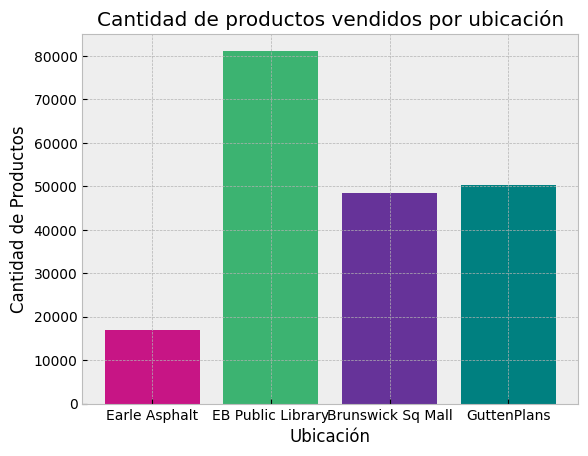

In [72]:
#Productos vendidos por locación
x = ['Earle Asphalt', 'EB Public Library', 'Brunswick Sq Mall', 'GuttenPlans']
y = [16939, 81117, 48430, 50314]
plt.bar(x, y, color = ['mediumvioletred','mediumseagreen', 'rebeccapurple', 'teal'])
plt.title('Cantidad de productos vendidos por ubicación')
plt.xlabel('Ubicación')
plt.ylabel('Cantidad de Productos')
plt.ylim(0, 85000)
plt.show()

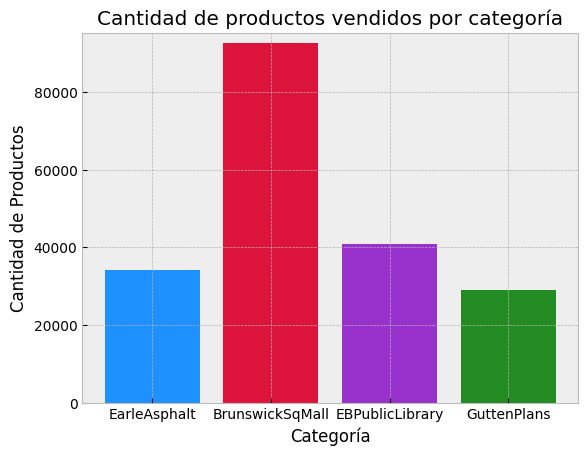

In [73]:
#Productos vendidos por categoría
Prod_cat2 = Prod_cat.sum()
plt.bar(Prod_cat.index, Prod_cat2, color = ['dodgerblue', 'crimson', 'darkorchid', 'forestgreen'])
plt.title('Cantidad de productos vendidos por categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Productos')
plt.ylim(0, 95000)
plt.show()

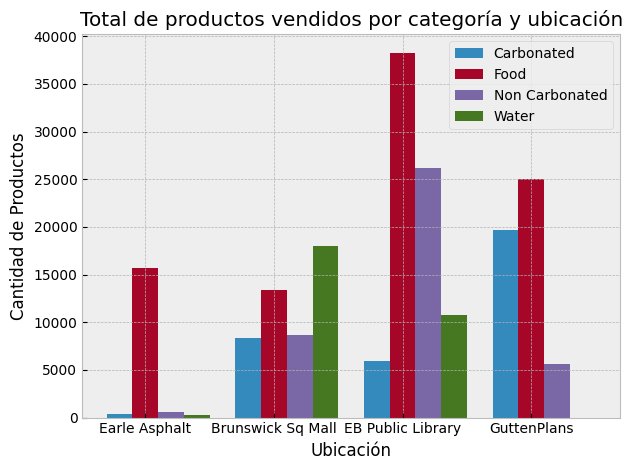

In [74]:
#Productos vendidos por ubicación y por categoría
x = Prod_cat3.index
x = np.arange(len(Prod_cat3.index))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x-width, Prod_cat3.Carbonated, width, label = 'Carbonated' )
rects2 = ax.bar(x, Prod_cat3.Food, width, label = 'Food' )
rects3 = ax.bar(x+width, Prod_cat3.NonCarbonated, width, label = 'Non Carbonated' )
rects4 = ax.bar(x+width+width, Prod_cat3.Water, width, label = 'Water' )
ax.set_ylabel('Cantidad de Productos') 
ax.set_xlabel('Ubicación')
ax.set_title('Total de productos vendidos por categoría y ubicación')
ax.set_xticks([0, 1, 2, 3], ['Earle Asphalt', 'Brunswick Sq Mall', 'EB Public Library', 'GuttenPlans'])
ax.legend()
fig.tight_layout()
plt.show()

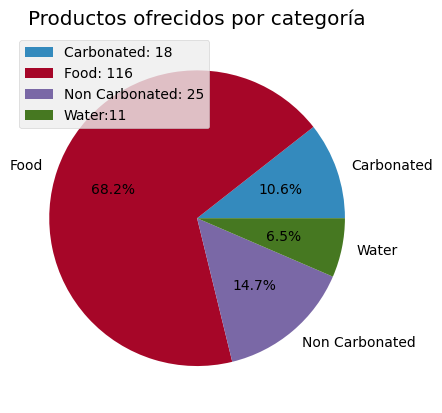

In [75]:
#Productos ofrecidos por categoría
A = np.array([18, 116, 25, 11])
B = ['Carbonated', 'Food', 'Non Carbonated', 'Water']
plt.pie(A, labels = B, autopct = '%0.1f%%')
plt.title('Productos ofrecidos por categoría')
plt.legend(['Carbonated: 18', 'Food: 116', 'Non Carbonated: 25', 'Water:11'], loc = 'best')
plt.show()

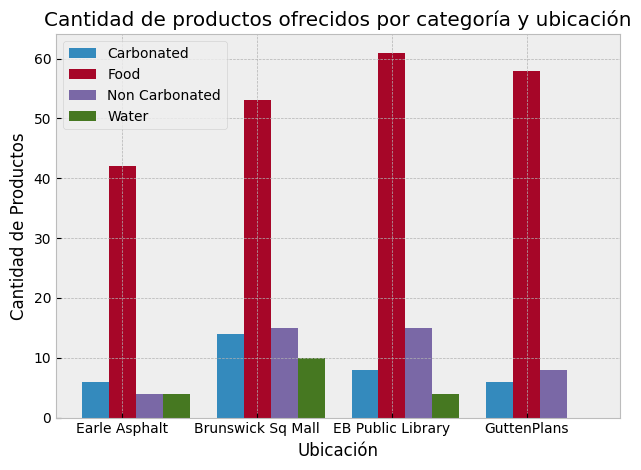

In [76]:
#Productos ofrecidos por ubicación y por categoría
x = df_cantprod.index
x = np.arange(len(df_cantprod.index))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x-width, df_cantprod.Carbonated, width, label = 'Carbonated' )
rects2 = ax.bar(x, df_cantprod.Food, width, label = 'Food' )
rects3 = ax.bar(x+width, df_cantprod.NonCarbonated, width, label = 'Non Carbonated' )
rects4 = ax.bar(x+width+width, df_cantprod.Water, width, label = 'Water' )
ax.set_ylabel('Cantidad de Productos') 
ax.set_xlabel('Ubicación')
ax.set_title('Cantidad de productos ofrecidos por categoría y ubicación')
ax.set_xticks([0, 1, 2, 3], ['Earle Asphalt', 'Brunswick Sq Mall', 'EB Public Library', 'GuttenPlans'])
ax.legend()
fig.tight_layout()
plt.show()

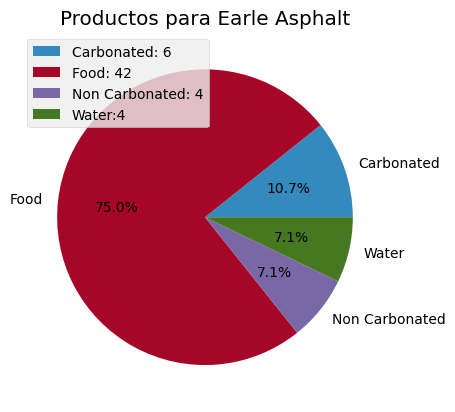

In [77]:
#Productos ofrecidos por ubicación
A = np.array([6, 42, 4, 4])
B = ['Carbonated', 'Food', 'Non Carbonated', 'Water']
plt.pie(A, labels = B, autopct = '%0.1f%%')
plt.title('Productos para Earle Asphalt')
plt.legend(['Carbonated: 6', 'Food: 42', 'Non Carbonated: 4', 'Water:4'], loc = 'best')
plt.show()

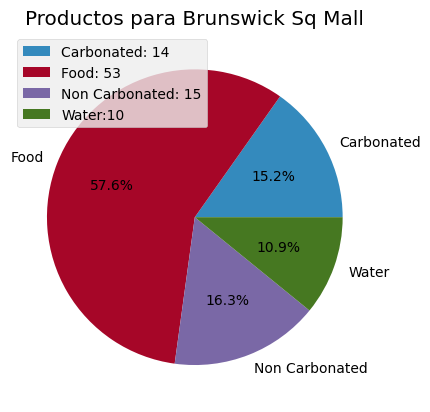

In [78]:
#Productos ofrecidos por ubicación
C = np.array([14, 53, 15, 10])
D = ['Carbonated', 'Food', 'Non Carbonated', 'Water']
plt.pie(C, labels = D, autopct = '%0.1f%%')
plt.title('Productos para Brunswick Sq Mall')
plt.legend(['Carbonated: 14', 'Food: 53', 'Non Carbonated: 15', 'Water:10'], loc = 'best')
plt.show()

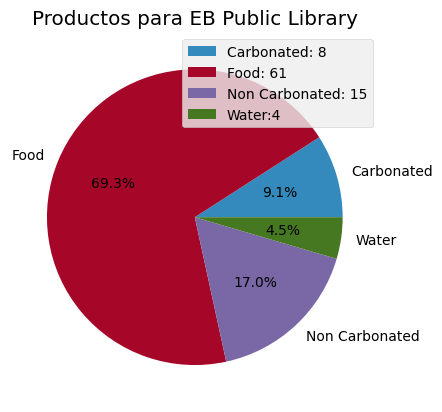

In [79]:
#Productos ofrecidos por ubicación
E = np.array([8, 61, 15, 4])
F = ['Carbonated', 'Food', 'Non Carbonated', 'Water']
plt.pie(E, labels = F, autopct = '%0.1f%%')
plt.title('Productos para EB Public Library')
plt.legend(['Carbonated: 8', 'Food: 61', 'Non Carbonated: 15', 'Water:4'], loc = 'best')
plt.show()

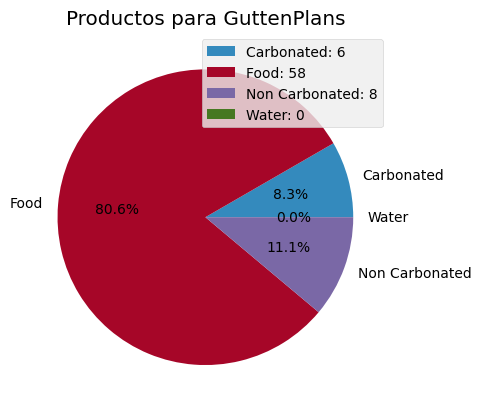

In [80]:
#Productos ofrecidos por ubicación
G = np.array([6, 58, 8, 0])
H = ['Carbonated', 'Food', 'Non Carbonated', 'Water']
plt.pie(G, labels = H, autopct = '%0.1f%%')
plt.title('Productos para GuttenPlans')
plt.legend(['Carbonated: 6', 'Food: 58', 'Non Carbonated: 8', 'Water: 0'], loc = 'best')
plt.show()

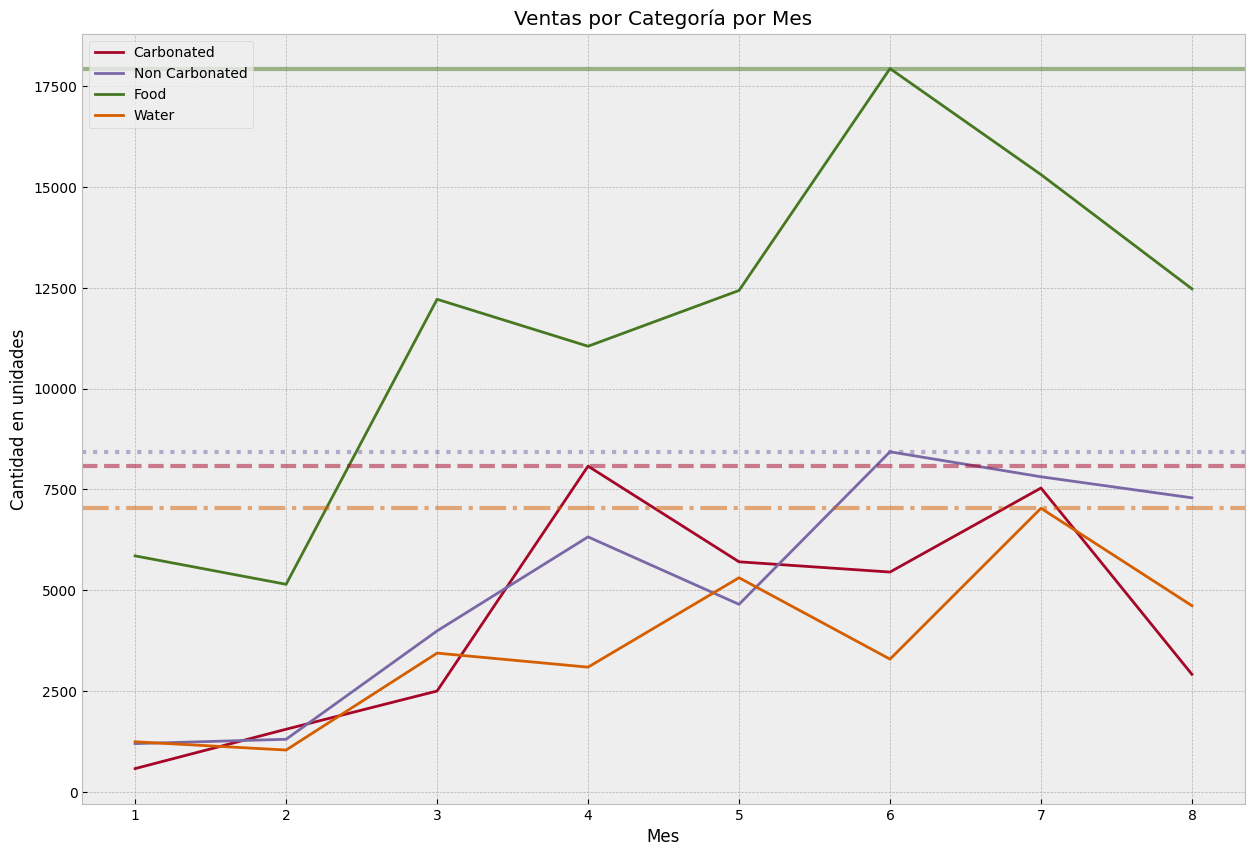

In [81]:
#Ventas por categoría por mes
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(Mensual_cat['Carbonated'], label = 'Carbonated', color = 'C1')
ax.plot(Mensual_cat['Non Carbonated'], label = 'Non Carbonated', color = 'C2')
ax.plot(Mensual_cat['Food'], label = 'Food', color = 'C3')
ax.plot(Mensual_cat['Water'], label = 'Water', color = 'C4')
maximo_Carb = Mensual_cat['Carbonated'].max()
maximo_NonCarb = Mensual_cat['Non Carbonated'].max()
maximo_Food = Mensual_cat['Food'].max()
maximo_Water = Mensual_cat['Water'].max()
ax.axhline (maximo_Carb, color = 'C1', linestyle = '--', alpha = 0.5, linewidth = 3, label = 'Máximo Carbonated' )
ax.axhline (maximo_NonCarb, color = 'C2', linestyle = ':', alpha = 0.5, linewidth = 3, label = 'Máximo Non Carbonated' )
ax.axhline (maximo_Food, color = 'C3', linestyle = '-', alpha = 0.5, linewidth = 3, label = 'Máximo Food' )
ax.axhline (maximo_Water, color = 'C4', linestyle = '-.', alpha = 0.5, linewidth = 3, label = 'Máximo Water' )
ax.set_title('Ventas por Categoría por Mes')
ax.set_ylabel('Cantidad en unidades')
ax.set_xlabel('Mes')
ax.legend(['Carbonated', 'Non Carbonated', 'Food', 'Water'], loc='upper left')
fig.show()

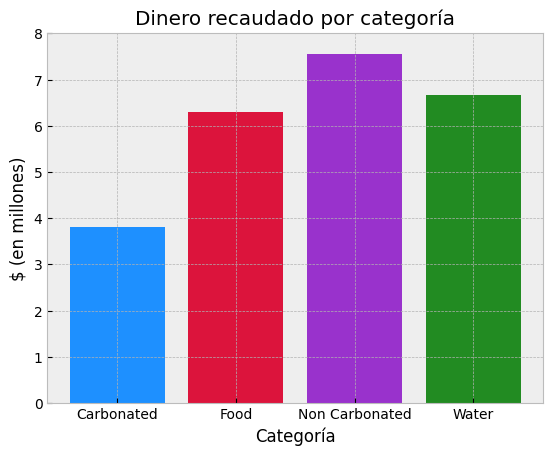

In [82]:
#Dinero por categoría
x = ['Carbonated', 'Food', 'Non Carbonated', 'Water']
y = [3.82, 6.29, 7.55, 6.66]
plt.bar(x, y, color = ['dodgerblue', 'crimson', 'darkorchid', 'forestgreen'])
plt.title('Dinero recaudado por categoría')
plt.xlabel('Categoría')
plt.ylabel('$ (en millones)')
plt.ylim(0, 8)
plt.show()

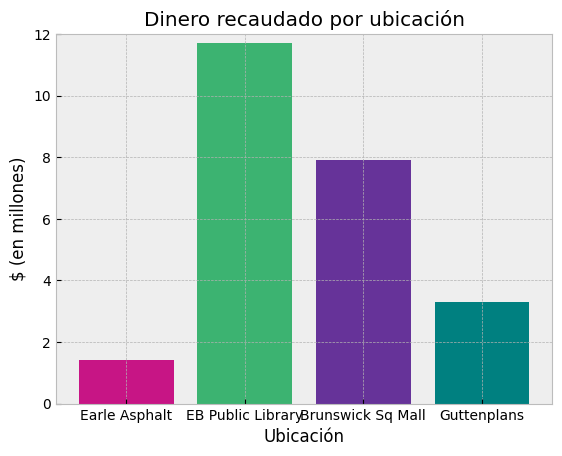

In [83]:
#Dinero por ubicación
x = ['Earle Asphalt', 'EB Public Library', 'Brunswick Sq Mall', 'Guttenplans']
y = [1.4, 11.7, 7.9, 3.3]
plt.bar(x, y, color = ['mediumvioletred', 'mediumseagreen', 'rebeccapurple', 'teal'])
plt.title('Dinero recaudado por ubicación')
plt.xlabel('Ubicación')
plt.ylabel('$ (en millones)')
plt.ylim(0, 12)
plt.show()

Text(0, 0.5, 'Cantidad vendida')

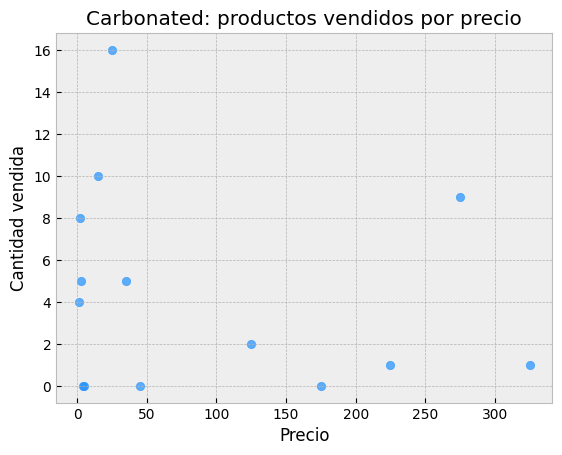

In [84]:
#Precio de venta y cantidad vendida
#Carbonated
precios = [1, 2, 3, 4, 5, 15, 25, 35, 45, 125, 175, 225, 275, 325]
vendidos_carb = [4, 8, 5, 0, 0, 10, 16, 5, 0, 2, 0, 1, 9,1]
fig, ax = plt.subplots()
ax.scatter(precios, vendidos_carb, c = 'dodgerblue', alpha=0.7)
ax.set_title('Carbonated: productos vendidos por precio')
ax.set_xlabel('Precio')
ax.set_ylabel('Cantidad vendida')

Text(0, 0.5, 'Cantidad vendida')

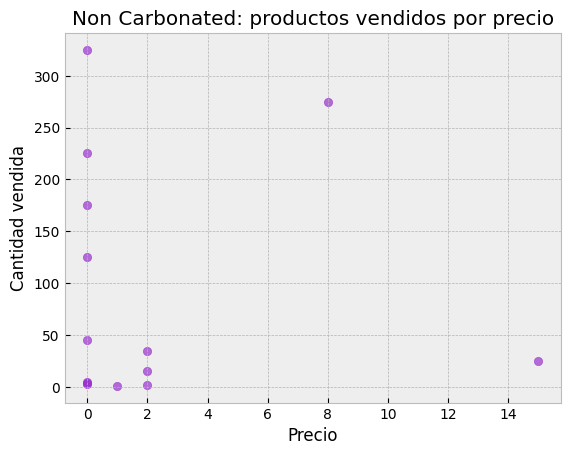

In [85]:
#Precio de venta y cantidad vendida
#NonCarbonated
precios = [1, 2, 3, 4, 5, 15, 25, 35, 45, 125, 175, 225, 275, 325]
vendidos_noncarb = [1, 2, 0, 0, 0, 2, 15, 2, 0, 0, 0, 0, 8, 0]
fig, ax = plt.subplots()
ax.scatter(vendidos_noncarb, precios, c = 'darkorchid', alpha=0.7)
ax.set_title('Non Carbonated: productos vendidos por precio')
ax.set_xlabel('Precio')
ax.set_ylabel('Cantidad vendida')

Text(0, 0.5, 'Cantidad vendida')

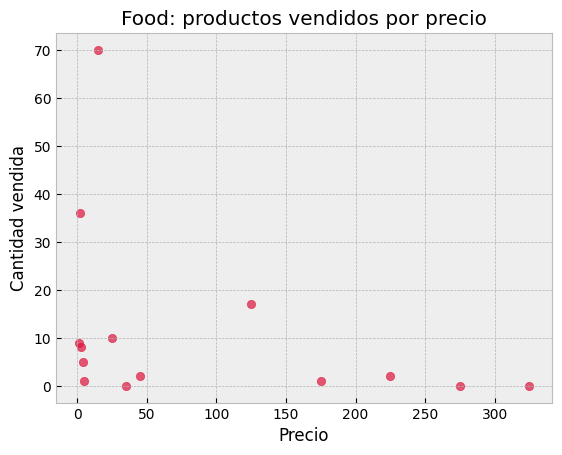

In [86]:
#Precio de venta y cantidad vendida
#Food
precios = [1, 2, 3, 4, 5, 15, 25, 35, 45, 125, 175, 225, 275, 325]
vendidos_food = [9, 36, 8, 5, 1, 70, 10, 0, 2, 17, 1, 2, 0, 0]
fig, ax = plt.subplots()
ax.scatter(precios, vendidos_food, c = 'crimson', alpha=0.7)
ax.set_title('Food: productos vendidos por precio')
ax.set_xlabel('Precio')
ax.set_ylabel('Cantidad vendida')

Text(0, 0.5, 'Cantidad vendida')

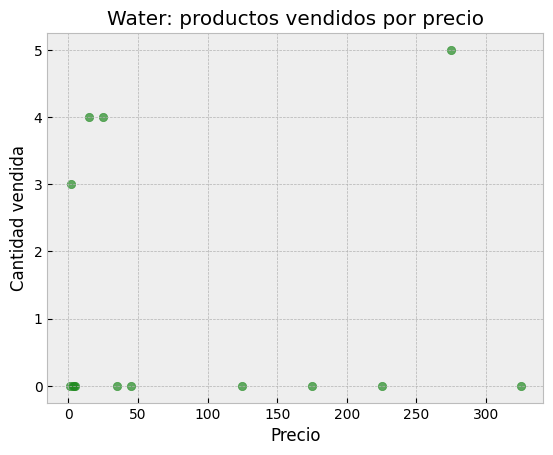

In [87]:
#Precio de venta y cantidad vendida
#Water
precios = [1, 2, 3, 4, 5, 15, 25, 35, 45, 125, 175, 225, 275, 325]
vendidos_water = [0, 3, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 5, 0]
fig, ax = plt.subplots()
ax.scatter(precios, vendidos_water, c = 'forestgreen', alpha=0.7)
ax.set_title('Water: productos vendidos por precio')
ax.set_xlabel('Precio')
ax.set_ylabel('Cantidad vendida')

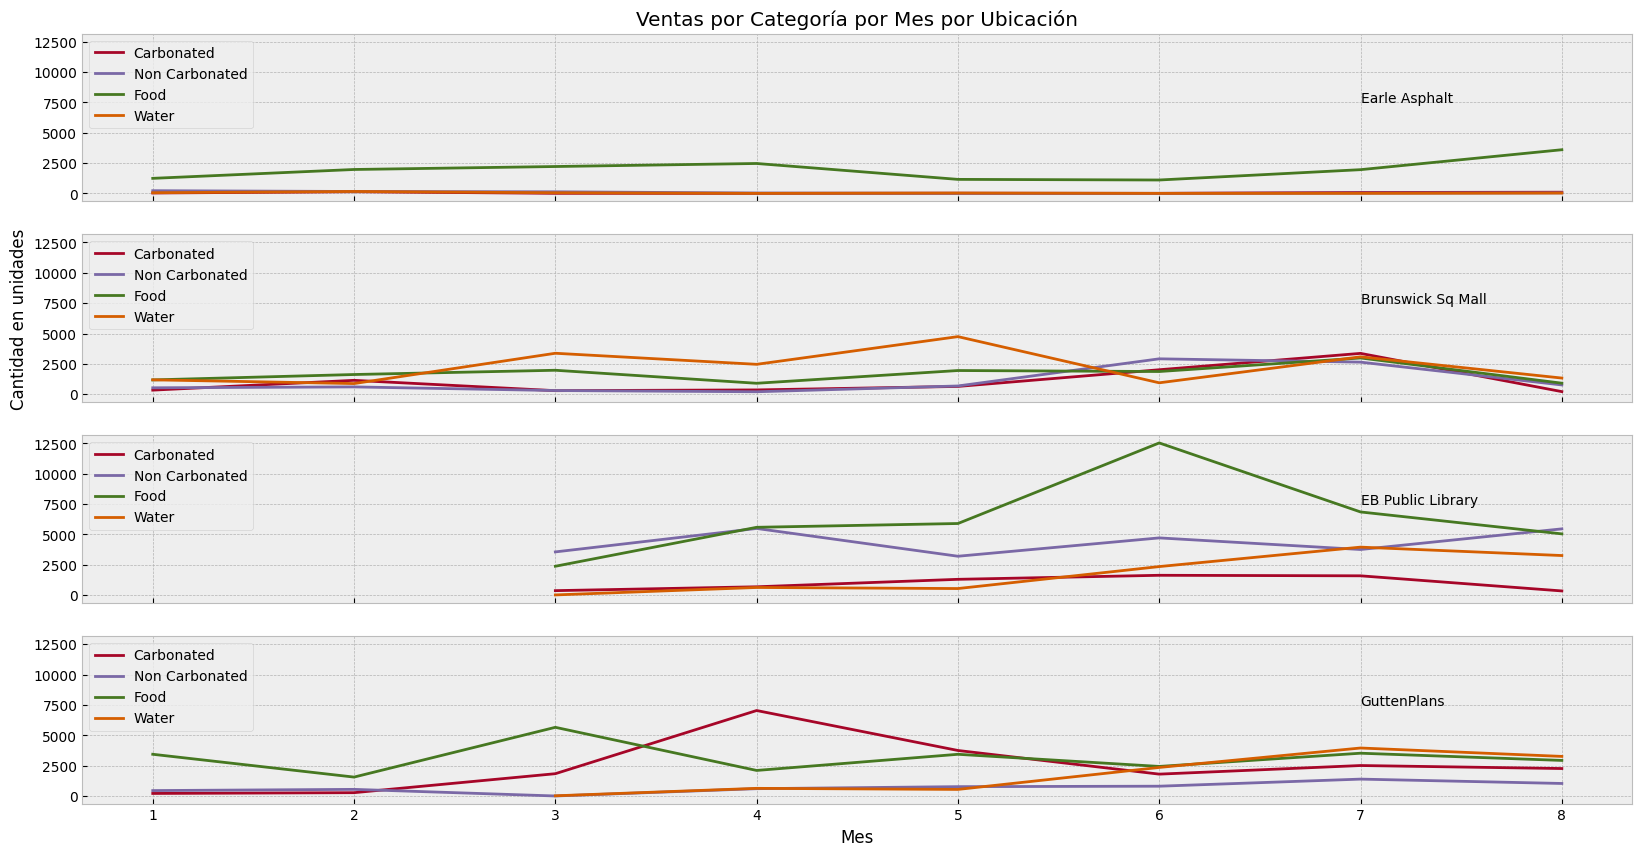

In [88]:
#Ventas por categoría por mes por ubicación
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,10), sharex= True, sharey= True)
ax[0].plot(EA_Category_Month['Carbonated'], label = 'Carbonated', color = 'C1')
ax[0].plot(EA_Category_Month['Non Carbonated'], label = 'Non Carbonated', color = 'C2')
ax[0].plot(EA_Category_Month['Food'], label = 'Food', color = 'C3')
ax[0].plot(EA_Category_Month['Water'], label = 'Water', color = 'C4')
ax[1].plot(BM_Category_Month['Carbonated'], label = 'Carbonated', color = 'C1')
ax[1].plot(BM_Category_Month['Non Carbonated'], label = 'Non Carbonated', color = 'C2')
ax[1].plot(BM_Category_Month['Food'], label = 'Food', color = 'C3')
ax[1].plot(BM_Category_Month['Water'], label = 'Water', color = 'C4')
ax[2].plot(EB_Category_Month['Carbonated'], label = 'Carbonated', color = 'C1')
ax[2].plot(EB_Category_Month['Non Carbonated'], label = 'Non Carbonated', color = 'C2')
ax[2].plot(EB_Category_Month['Food'], label = 'Food', color = 'C3')
ax[2].plot(EB_Category_Month['Water'], label = 'Water', color = 'C4')
ax[3].plot(GP_Category_Month['Carbonated'], label = 'Carbonated', color = 'C1')
ax[3].plot(GP_Category_Month['Non Carbonated'], label = 'Non Carbonated', color = 'C2')
ax[3].plot(GP_Category_Month['Food'], label = 'Food', color = 'C3')
ax[3].plot(EB_Category_Month['Water'], label = 'Water', color = 'C4')
ax[0].set_title('Ventas por Categoría por Mes por Ubicación')
ax[1].set_ylabel('Cantidad en unidades')
ax[3].set_xlabel('Mes')
ax[0].legend(['Carbonated', 'Non Carbonated', 'Food', 'Water'], loc='upper left')
ax[1].legend(['Carbonated', 'Non Carbonated', 'Food', 'Water'], loc='upper left')
ax[2].legend(['Carbonated', 'Non Carbonated', 'Food', 'Water'], loc='upper left')
ax[3].legend(['Carbonated', 'Non Carbonated', 'Food', 'Water'], loc='upper left')
ax[0].annotate('Earle Asphalt', xy=(7,7500))
ax[1].annotate('Brunswick Sq Mall', xy=(7,7500))
ax[2].annotate('EB Public Library', xy=(7,7500))
ax[3].annotate('GuttenPlans', xy=(7,7500))

fig.show()


#3.0 Entrenamiento de Modelos de ML

##3.1 Regresión Lineal

In [89]:
data.describe().T

count         mean           std  min  25%    50%    75%  \
Type        6441.0     0.333178      0.471386  0.0  0.0    0.0    1.0   
LineTotal   6441.0    26.617606     53.564460  1.0  3.0   15.0   15.0   
RQty        6441.0     1.013352      0.121361  1.0  1.0    1.0    1.0   
RPrice      6441.0    26.845210     53.778997  1.0  3.0   15.0   15.0   
TransTotal  6441.0    30.553951     63.949657  1.0  3.0   15.0   15.0   
Money       6441.0  3774.665735  14847.345218  1.0  9.0  225.0  225.0   

                 max  
Type             1.0  
LineTotal      325.0  
RQty             3.0  
RPrice         325.0  
TransTotal     625.0  
Money       171875.0

In [90]:
#Intentaremos ver qué relación hay entre el precio (RPrice) y la cantidad vendida (TransTotal)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6441 entries, 0 to 6441
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TransDate   6441 non-null   datetime64[ns]
 1   Location    6441 non-null   object        
 2   Product     6441 non-null   object        
 3   Category    6441 non-null   object        
 4   Type        6441 non-null   float64       
 5   LineTotal   6441 non-null   float64       
 6   RQty        6441 non-null   float64       
 7   RPrice      6441 non-null   float64       
 8   TransTotal  6441 non-null   float64       
 9   Money       6441 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 553.5+ KB


<ipython-input-91-e56a6d953391>:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



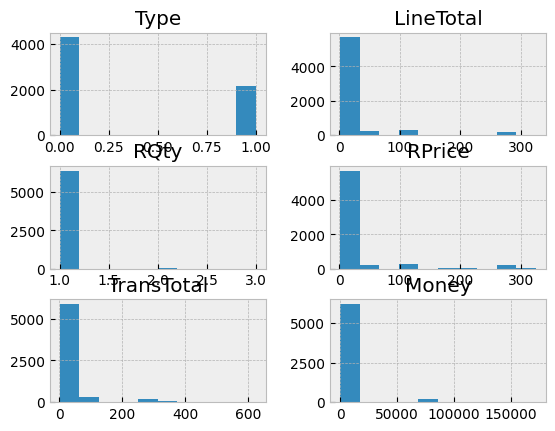

In [91]:
data.drop(['TransDate','Location', 'Product', 'Category', ],1).hist()
plt.show()

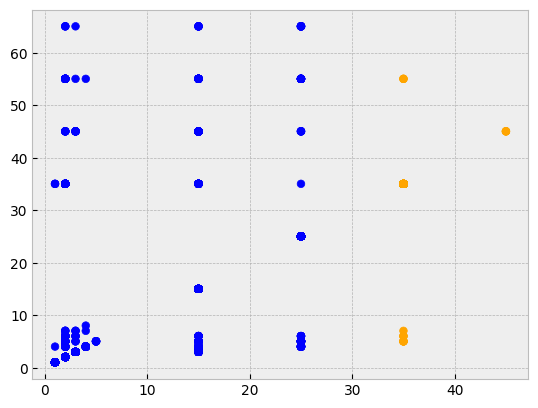

In [92]:
#Vamos a filtrar los datos del precio para quedarnos con los registros con menos de 90
#También con los que tengan menos de 100 transacciones. 
#Graficaremos de azul los puntos con menos de 27 (la media del precio) y en naranja los que tengan más	
# Vamos a RECORTAR los datos en la zona donde se concentran más los puntos
# esto es en el eje X: entre 0 y 90
# y en el eje Y: entre 0 y 100
filtered_data = data[(data['RPrice'] <= 90) & (data['TransTotal'] <= 100)]
 
colores=['orange','blue']
tamanios=[30,60]
 
f1 = filtered_data['RPrice'].values
f2 = filtered_data['TransTotal'].values
 
# Vamos a pintar en colores los puntos por debajo y por encima de la media de Precio
asignar=[]
for index, row in filtered_data.iterrows():
    if(row['RPrice']>27):
        asignar.append(colores[0])
    else:
        asignar.append(colores[1])
    
plt.scatter(f1, f2, c=asignar, s=tamanios[0])
plt.show()

In [93]:
dataX =filtered_data[["RPrice"]]
X_train = np.array(dataX)
y_train = filtered_data['TransTotal'].values
 
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(X_train, y_train)
 
# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred = regr.predict(X_train)
 
# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_train, y_pred))

Coefficients: 
 [0.91725657]
Independent term: 
 2.011514826809419
Mean squared error: 61.97
Variance score: 0.51


##3.2 Random Forest

In [94]:
variables_independientes = ['Type', 'RPrice', 'TransTotal', 'Money']
df_new = data[variables_independientes]
X = df_new.drop('Type', axis=1)
y = df_new['Type']
pd.get_dummies(X)
X_dummies = pd.get_dummies(X)

In [96]:
#Separación train / test
X_trainRF,X_testRF, y_trainRF, y_testRF = train_test_split(X_dummies, y)

rfc = RandomForestClassifier()

#Entrenamiento
rfc.fit(X_trainRF, y_trainRF)

#Predicción
y_predRF = rfc.predict(X_testRF)

###3.2.1 Resultados

In [97]:
resultado_RF = pd.DataFrame(y_predRF, columns = ['prediccion'])
resultado_RF['real'] = y_testRF.reset_index()['Type']
resultado_RF['diferencia'] = resultado_RF.prediccion == resultado_RF.real
resultado_RF

prediccion  real  diferencia
0            0.0   0.0        True
1            0.0   1.0       False
2            0.0   0.0        True
3            0.0   1.0       False
4            0.0   0.0        True
...          ...   ...         ...
1606         0.0   0.0        True
1607         0.0   0.0        True
1608         0.0   0.0        True
1609         0.0   0.0        True
1610         0.0   0.0        True

[1611 rows x 3 columns]

###3.2.2 Evaluación

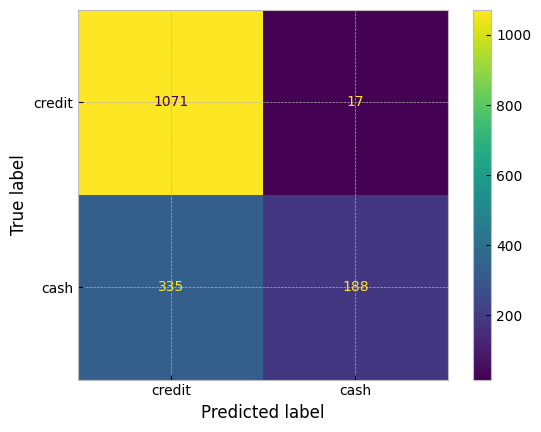

In [125]:
cm_RF = confusion_matrix(y_testRF, y_predRF, labels = rfc.classes_)
cm_RF_disp= ConfusionMatrixDisplay(confusion_matrix=cm_RF,display_labels=["credit","cash"])
cm_RF_disp.plot()

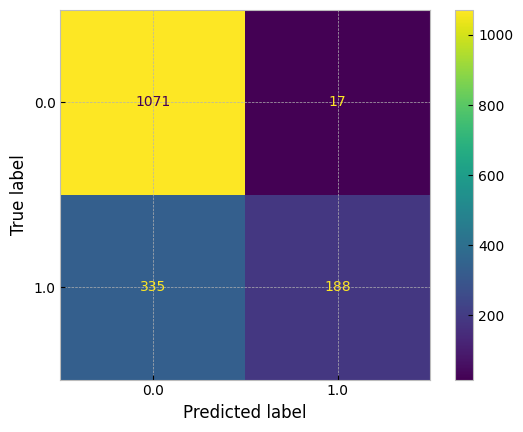

In [118]:
#desde el estimator
ConfusionMatrixDisplay.from_estimator(rfc,X_testRF, y_testRF)

In [101]:
accuracy_score(y_testRF, y_predRF)

0.7815021725636251

In [191]:
from sklearn.metrics import f1_score

In [192]:
f1_score(y_testRF, y_predRF, zero_division=1)

0.5945165945165946

In [193]:
from sklearn.metrics import classification_report
#Sensibilidad
#tn(truenegatives), fp(falsopositivos), fn(falsonegativos), tp(truepositivos)
tp,fp,tn,fn = cm_RF.ravel()
sensibilidad1 = tp/(tp+fn)
sensibilidad2 = tn/(tn+fp)

print(sensibilidad1, sensibilidad2, (sensibilidad1+sensibilidad2)/2)

0.8506751389992058 0.9517045454545454 0.9011898422268756


In [242]:
#Especifidad
from sklearn.metrics import recall_score
print(recall_score(y_testRF, y_predRF,pos_label=0))#'Cash'
print(recall_score(y_testRF, y_predRF,pos_label = 1))#'Credit'

0.9324796274738067
0.4801864801864802


In [243]:
print(classification_report(y_testRF, y_predRF))

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       859
         1.0       0.78      0.48      0.59       429

    accuracy                           0.78      1288
   macro avg       0.78      0.71      0.72      1288
weighted avg       0.78      0.78      0.77      1288



### 3.2.3 Cross validation 

In [171]:
skf = StratifiedKFold(n_splits=5)

In [172]:
#Modelo
model = RandomForestClassifier(random_state=1, n_estimators=30, criterion="gini",max_depth=4)
#Listra para guardar accuracy
lista_ac = []
for train_index, test_index in skf.split(X,y):
  #Dividimos los datos en conjuntos de entrenamiento y prueba utilizando los índices obtenidos de la validación cruzada
  X_trainRF, X_testRF = X.iloc[train_index], X.iloc[test_index]
  y_trainRF, y_testRF = y.iloc[train_index], y.iloc[test_index]

  #Entrenamos el modelo utilizando los datos de entrenamiento
  model.fit(X_trainRF, y_trainRF)

  #Evaluamos el modelo utilizando los datos de prueba y calculamos la puntuación de RMSE
  y_predRF = model.predict(X_testRF)

  # Agregamos la puntuación de RMSE a la lista de puntuaciones de validación cruzada
  lista_ac.append(accuracy_score(y_testRF,y_predRF))

#Prints
print("Lista de posible precision:",lista_ac)
print("\nMaxima precision que puede ser obtenida de este modelo:", max(lista_ac)*100,"%")
print("\nMinima precision:", min(lista_ac)*100,"%")
print("\nOverall Accuracy:", mean(lista_ac)*100,"%")
print("\nStandard Deviation is:", stdev(lista_ac))

Lista de posible precision: [0.7858805275407292, 0.75, 0.7414596273291926, 0.7492236024844721, 0.781832298136646]

Maxima precision que puede ser obtenida de este modelo: 78.58805275407292 %

Minima precision: 74.14596273291926 %

Overall Accuracy: 76.1679211098208 %

Standard Deviation is: 0.020568351661820257


###3.2.4 PCA
¿Que pasaria si ahora usaramos PCA para poder reducir las variables y ver que tanta precision sacamos del modelo?

In [230]:
#instanciar modelo
scaler = StandardScaler()

#ajuste
X_train_std = scaler.fit_transform(X_trainRF)
X_test_std = scaler.transform(X_testRF)
y_trainRF = np.array(y_trainRF)

#instanciar
pca = PCA(n_components=2)

# Ajuste PCA
X_train_pca = pca.fit_transform(X_train_std)

X_test_pca = pca.transform(X_test_std)

print('PCA components', pca)

print("shape of X_pca", X_test_pca )
expl = pca.explained_variance_ratio_*100



PCA components PCA(n_components=2)
shape of X_pca [[-0.41391743 -0.02067882]
 [-0.41391743 -0.02067882]
 [-0.65760641 -0.07400982]
 ...
 [-0.6420007  -0.02772066]
 [-0.20210787  0.01821547]
 [-0.41391743 -0.02067882]]


In [231]:
print('variance ratio', expl)
print('suma:',sum(expl[0:2]))

variance ratio [92.43192701  5.70934358]
suma: 98.14127058659885


In [229]:
X_test_pca

array([[-0.41391743, -0.02067882],
       [-0.41391743, -0.02067882],
       [-0.65760641, -0.07400982],
       ...,
       [-0.6420007 , -0.02772066],
       [-0.20210787,  0.01821547],
       [-0.41391743, -0.02067882]])

In [165]:
#Accuracy del pca
pca = PCA(n_components=2) 

X_train = pca.fit_transform(X_trainRF) 

X_test = pca.transform(X_testRF)

model_rf = RandomForestClassifier(max_depth=5, random_state=1) 

model_rf.fit(X_trainRF, y_trainRF) 

y_predRF = model_rf.predict(X_testRF)

In [166]:
accuracy = accuracy_score(y_testRF, y_predRF)

print("Accuracy:", accuracy)

Accuracy: 0.7790192427063936


Bueno podemos ver que obtuvimos una precision del 77% a comparacion de antes donde obtuvimos un 76%

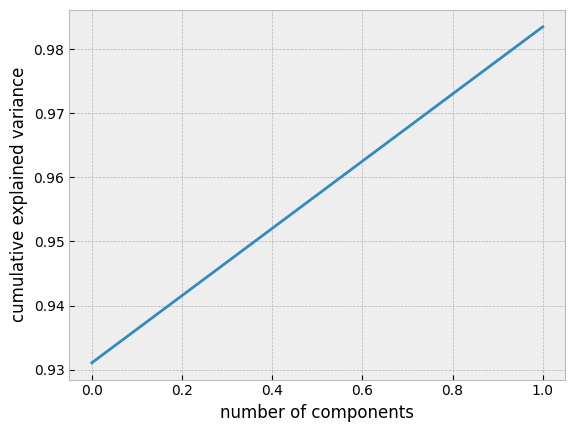

In [163]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### 3.2.5 RandommizedSearchCV

In [167]:
#vamos a buscar los hiperparametros del modelo
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [168]:
#Vamos armar nuestra parilla de parametros 
params_grid = {
        'criterion':['gini','entropy'],
        'random_state': [1,2,3],
        'max_depth': [1,2,4],
        }

In [176]:
random = RandomizedSearchCV(model,params_grid,scoring="accuracy", n_jobs=-1, cv=3)
random.fit(X_trainRF, y_trainRF)
print("Mejores parametros", random.best_params_)
print("Mejor score de random", random.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_testRF, random.predict(X_testRF)), 5)}')

Mejores parametros {'random_state': 3, 'max_depth': 4, 'criterion': 'gini'}
Mejor score de random 0.7564497461866985
Accuracy del modelo = 0.7795


Con esto concluimos que todo el trabajo aplicado a nuestro modelo obtuvo una presicion del casi 78% lo cual es muy buena aproximacion para el trabajo empleado pero no nos podemos quedar con un solo modelo de prueba por lo tanto vamos a proceder con 1 mas.

##3.3 Decision Tree Classifier (DTC)

In [177]:
#Procemos a la parte de encoding
variables_independientes = ['Type', 'RPrice', 'TransTotal', 'Money']
df_new2 = data[variables_independientes]
X = df_new2.drop('Type', axis=1)


In [178]:
X_45 = pd.get_dummies(X)
X_45

RPrice  TransTotal   Money
0       35.0        35.0  1225.0
1       35.0         5.0   175.0
2       15.0         5.0    75.0
3       15.0        15.0   225.0
4       35.0        35.0  1225.0
...      ...         ...     ...
6437     2.0         6.0    12.0
6438     2.0         6.0    12.0
6439     2.0         6.0    12.0
6440    25.0        25.0   625.0
6441    15.0        15.0   225.0

[6441 rows x 3 columns]

In [179]:
y = df_new.Type
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6437    1.0
6438    1.0
6439    1.0
6440    1.0
6441    0.0
Name: Type, Length: 6441, dtype: float64

In [180]:
#Separación train / test
X_trainDT, X_testDT, y_trainDT, y_testDT = train_test_split(X,y, random_state =42, test_size=0.3)

dtc = DecisionTreeClassifier(max_depth = 4, random_state= 42)

dtc.fit(X_trainDT, y_trainDT)

y_predDT = dtc.predict(X_testDT)

###3.3.1 Resultados

In [181]:
resultado_DT = pd.DataFrame(y_predDT, columns = ['prediccion'])
resultado_DT['real'] = y_testDT.reset_index()['Type']
resultado_DT['diferencia'] = resultado_DT.prediccion == resultado_DT.real
resultado_DT

prediccion  real  diferencia
0            0.0   0.0        True
1            1.0   1.0        True
2            1.0   1.0        True
3            0.0   0.0        True
4            1.0   1.0        True
...          ...   ...         ...
1928         1.0   1.0        True
1929         1.0   1.0        True
1930         0.0   0.0        True
1931         0.0   0.0        True
1932         0.0   1.0       False

[1933 rows x 3 columns]

###3.3.2 Evaluacion

In [182]:
#Evaluación
confusion_matrix(y_testDT, y_predDT)

array([[1222,   75],
       [ 368,  268]])

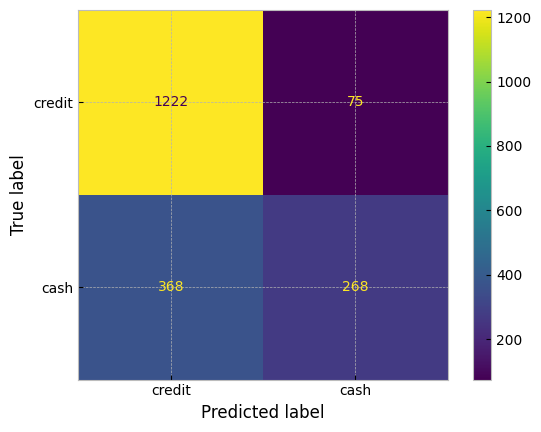

In [183]:
#ahora aplicamos un grafico de matris
cm_dt = confusion_matrix(y_testDT, y_predDT, labels = dtc.classes_)
cm_dt_disp= ConfusionMatrixDisplay(confusion_matrix =cm_dt ,display_labels=["credit","cash"]) 
cm_dt_disp.plot()

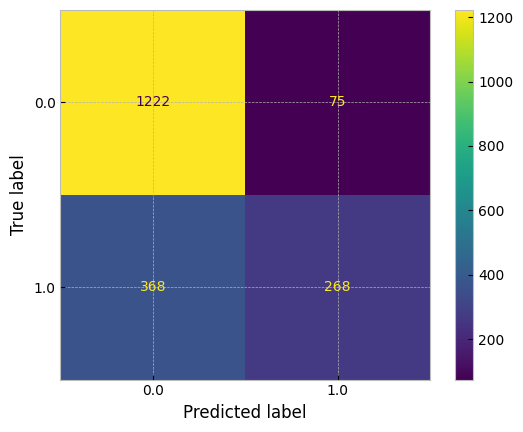

In [184]:
#desde el estimator
ConfusionMatrixDisplay.from_estimator(dtc,X_testDT, y_testDT)

In [185]:
accuracy_score(y_testDT, y_predDT)

0.7708225556130367

In [199]:

#Sensibilidad
#tn(truenegatives), fp(falsopositivos), fn(falsonegativos), tp(truepositivos)
tp,fp,tn,fn = cm_dt.ravel()
sensibilidad1 = tp/(tp+fn)
sensibilidad2 = tn/(tn+fp)

print(sensibilidad1, sensibilidad2, (sensibilidad1+sensibilidad2)/2)

0.8201342281879195 0.8306997742663657 0.8254170012271426


In [187]:
f1_score
f1_score(y_testDT, y_predDT, zero_division=1)

0.5474974463738509

In [203]:
#Especifidad(recall)
print(recall_score(y_testDT, y_predDT,pos_label=1))#'Cash'
print(recall_score(y_testDT, y_predDT,pos_label = 0))#'Credit'

0.42138364779874216
0.9421742482652274


In [205]:

print(classification_report(y_testDT, y_predDT))

              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85      1297
         1.0       0.78      0.42      0.55       636

    accuracy                           0.77      1933
   macro avg       0.77      0.68      0.70      1933
weighted avg       0.77      0.77      0.75      1933



###3.3.3 Cross validation

In [206]:
#Modelo
model2 = DecisionTreeClassifier(random_state=1,criterion="gini",max_depth=4) #n_estimators=30#
#Listra para guardar accuracy
lista_ac2 = []
for train_index, test_index in skf.split(X,y):
  #Dividimos los datos en conjuntos de entrenamiento y prueba utilizando los índices obtenidos de la validación cruzada
  X_trainDT, X_testDT = X.iloc[train_index], X.iloc[test_index]
  y_trainDT, y_testDT = y.iloc[train_index], y.iloc[test_index]

  #Entrenamos el modelo utilizando los datos de entrenamiento
  model2.fit(X_trainDT, y_trainDT)

  #Evaluamos el modelo utilizando los datos de prueba y calculamos la puntuación de RMSE
  y_predDT = model2.predict(X_testDT)

  # Agregamos la puntuación de RMSE a la lista de puntuaciones de validación cruzada
  lista_ac2.append(accuracy_score(y_testDT,y_predDT))

#Prints
print("Lista de posible precision:",lista_ac2)
print("\nMaxima precision que puede ser obtenida de este modelo:", max(lista_ac2)*100,"%")
print("\nMinima precision:", min(lista_ac2)*100,"%")
print("\nOverall Accuracy:", mean(lista_ac2)*100,"%")
print("\nStandard Deviation is:", stdev(lista_ac2))

Lista de posible precision: [0.7874321179208689, 0.75, 0.7406832298136646, 0.7523291925465838, 0.7771739130434783]

Maxima precision que puede ser obtenida de este modelo: 78.74321179208688 %

Minima precision: 74.06832298136646 %

Overall Accuracy: 76.15236906649191 %

Standard Deviation is: 0.019797948846134793


###3.3.4 PCA
Nuevamente nos hacemos la pregunta como paso con el modelo anterior, teniendo en cuenta que ahora nuestro mejor % de precision fue 76% veremos cuando podemos reducir con el PCA para obtener una mejor aproximacion.

In [228]:
#instanciar modelo
scaler2 = StandardScaler()
#ajuste
X_train_DT = scaler.fit_transform(X_trainDT)
X_test_std = scaler.transform(X_testDT)
y_trainDT = np.array(y_trainDT)
#instanciar
pca2 = PCA(n_components=2)
# Ajuste PCA
X_train_pca2 = pca.fit_transform(X_train_std)

X_test_pca2 = pca.transform(X_test_std)

print('PCA components', pca2)

print("shape of X_pca", X_test_pca2 )
expl = pca.explained_variance_ratio_*100



PCA components PCA(n_components=2)
shape of X_pca [[-0.41391743 -0.02067882]
 [-0.41391743 -0.02067882]
 [-0.65760641 -0.07400982]
 ...
 [-0.6420007  -0.02772066]
 [-0.20210787  0.01821547]
 [-0.41391743 -0.02067882]]


In [224]:
print('variance ratio', expl)
print('suma:',sum(expl[0:2]))

variance ratio [92.43192701  5.70934358]
suma: 98.14127058659902


In [221]:
pca.explained_variance_ratio_*100

array([92.43192701,  5.70934358])

In [222]:
X_test_pca2

array([[-0.41391743, -0.02067882],
       [-0.41391743, -0.02067882],
       [-0.65760641, -0.07400982],
       ...,
       [-0.6420007 , -0.02772066],
       [-0.20210787,  0.01821547],
       [-0.41391743, -0.02067882]])

In [233]:
#Accuracy del pca
pca2 = PCA(n_components=2) 

X_train = pca.fit_transform(X_trainDT) 

X_test = pca.transform(X_testDT)

model_dt = DecisionTreeClassifier(max_depth=5, random_state=1) 

model_dt.fit(X_trainDT, y_trainDT) 

y_predDT = model_dt.predict(X_testDT)

In [234]:
accuracy = accuracy_score(y_testDT, y_predDT)

print("Accuracy:", accuracy)

Accuracy: 0.7841614906832298


Ahora obtuvimos un 78% de precision un 2% mejor en comparacion con lo anterior

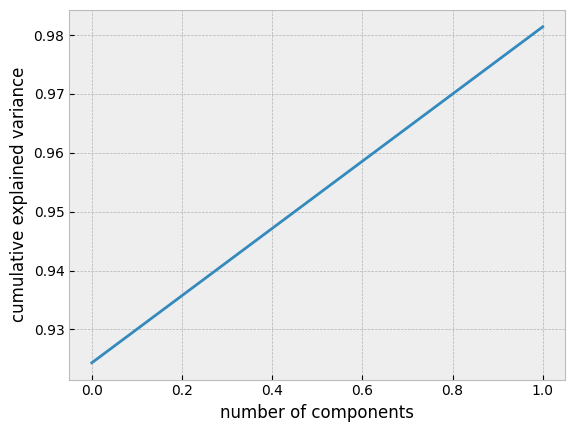

In [232]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### 3.3.5 RandommizedSearchCV

In [235]:
#vamos a buscar los hiperparametros del modelo
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [236]:
params_grid2 = {
        'criterion':['gini','entropy'],
        'random_state': [1,2,3],
        'max_depth': [1,2,4],
        }

In [237]:
random2 = RandomizedSearchCV(model2,params_grid2,scoring="accuracy", n_jobs=-1, cv=3)
random2.fit(X_trainDT, y_trainDT)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    random_state=1),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 4],
                                        'random_state': [1, 2, 3]},
                   scoring='accuracy')

In [238]:
print("Mejores parametros", random2.best_params_)
print("Mejor score de random2", random2.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_testDT, random2.predict(X_testDT)), 5)}')

Mejores parametros {'random_state': 1, 'max_depth': 4, 'criterion': 'entropy'}
Mejor score de random2 0.7580014866514385
Accuracy del modelo = 0.77717


Finalizado nuestro segundo estudio de este modelo podemos observar que tiene una precision del 77 % al igual que su comparacion contra el modelo de Random Forest ambos se encuentran proximos al 78%, esto nos permite decir que ambos modelos trabajan de forma parecida dandonos asi unas buenas aproximaciones.
Si igual se decidiera decir por una cuestion mas precisa el modelo mas certero fue el RF.

# 4.0 Anexo
### Data Profiling

Como un extra dejamos aqui expuesto un paranoma mas especifico de lo que fue nuestro Dataframe, esto muestra un analisis,monitoreo y detección de datos de una manera mas  fácil.

In [239]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 22.6 MB 22.1 MB/s 0:00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 8.8 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=345992 sha256=36abd7c3929112c0665938a126763dcbee1b4c142a7140472e602ee045dc19d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-4zg9ev0c/wheels/43/c8/f4/c0ebc32d7f20fe89d0e92d90eaeef5f0c0594a89b6bc16b352
Successfully built ydata-profiling
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninsta

In [240]:
import ydata_profiling

In [241]:
profile = ydata_profiling.ProfileReport(data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#5.0 Insights y Recomendaciones

##5.1 Insights y recomendaciones generales

###Insights

* Según la cantidad de productos vendidos, las locaciones quedan en las siguientes posiciones:
  1. EB Public Library
  2. Guttenplan's
  3. Brunswicks Sq Mall
  4. Earle Asphalt
* Al analizar el dinero recaudado en cada ubicación, las posiciones son las siguientes: 
  1. EB Public Library
  2. Brunswick Sq Mall
  3. Guttenplan's
  4. Earle Asphalt
* Considerando el total de transacciones, las ventas por categoría quedan de la siguiente manera:
  1. Food
  2. Non Carbonated
  3. Carbonated
  4. Water
* Para tres de las cuatro ubicaciones, Food es la categoría más vendida y Water, la menos vendida. Non carbonated es la más vendida para una sola de las ubicaciones mientras que Carbonated es la menos vendida para una sola ubicación.  
* La recaudación por categoría, arroja los siguientes resultados:
  1. Non Carbonated
  2. Water
  3. Food
  4. Carbonated
* Mucha variedad de productos ofrecidos por categoría, mayoritariamente para la categoría Food, más allá de que no se encuentran todos los productos en todas las ubicaciones.  
* El promedio de venta mensual es de 24.600 transacciones. Sólo tres de los ocho meses analizados no logran alcanzarlo, con marzo apenas por debajo del promedio y enero y febrero muy por debajo. Julio y junio, en ese orden, son los meses con mayores transacciones, muy por encima del promedio.
* Junio es el mes con pico de ventas de las categoría Food y Non Carbonated. Para la categoría Carbonated, el máximo de ventas se registra en abril; mientras que para Water es en julio. 
* Los máximos de ventas considerando las ubicaciones son abril para Guttenplan's, mayo para Brunswick Sq Mall, junio para EB Public Library y agosto para Earle Asphalt. 


###Conclusiones y recomendaciones

A mayor cantidad de ventas se espera mayor recaudación. Esta lógica puede verse claramente cuando analizamos las ventas por ubicación. Sin embargo, cuando lo hacemos respecto a las categorías, los resultados están muy lejos de lo esperado. Esto está directamente relacionado al precio de venta de los productos. La mayoría de los productos ofrecidos se encuentran entre 1 y 35 inclusive; por encima de los 175 y hasta los 325 (precio de venta más caro), la variedad se reduce notablemente. 
En cuanto a la estacionalidad, los meses de enero y febrero son los de menos ventas, como es de esperarse, dadas las bajas temperaturas y los gastos producidos por las fiestas. Por el contrario, los meses correspondientes al verano son los de más ventas, alentado por la llegada de mayor turismo y por el hecho de que los residentes se encuentren de vacaciones y más propensos a realizar gastos y consumir más de lo frecuente. 

La recomendación sería sacar de la venta aquellos productos que, más allá de su precio, registren una baja demanda en general. De los 170 productos ofrecidos, 42 de ellos se vendieron mensualmente en promedio menos de 10 unidades (menos de 3 por ubicación). Esto permitiría poder cargar las máquinas con mayor cantidad de los productos más vendidos e incluso probar con mercadería nueva, con un rango de precios incluso más altos. 

Que siempre estén los mismos productos en cada máquina, genera una gran previsibilidad y, en consecuencia, poco entusiasmo por parte de los clientes. Por ejemplo, que todos los meses haya 3 productos por categoría nuevos, que al mes siguiente serán reemplazados por otros nunca antes puestos a la venta (o que hace mucho tiempo hayan sido ofrecidos), podría aumentar la curiosidad en los clientes por visitar cada máquina y ver que es lo nuevo que se ofrece por tiempo limitado, lo que podría aumentar la venta en general de cada ubicación. Esto podría hacerse tomando como punto de referencia la estacionalidad, ofreciendo así bebidas en los meses de verano y alimentos más calóricos en el invierno.    



##5.2 Insights y recomendaciones Earle Asphalt

###Insights

* Ubicación con la menor cantidad de ventas (mucha diferencia con las otras ubicaciones)
* Ubicación con menor recaudación
* Categoría más vendida "Food" (representa más del 90% de las ventas totales)
* Pocas ventas en las demás categorías

###Recomendaciones

* Disminuir el stock de agua y bebidas no gasificadas, para tener más productos de las categorías más vendidas
* Dentro de las categorías más vendidas ("Food", "Non Carbonated"), aumentar el stock de los productos más vendidos e incorporar la oferta de productos más caros

##5.3 Insights y recomendaciones Brunswick Sq Mall

###Insights

* Ubicación en el tercer puesto en cantidad de ventas
* Segunda ubicación que más recaudó
* La categoría más vendida es "Water", seguida por "Food"

###Recomendaciones

* Disminuir la oferta de las categorías menos vendidas (gaseosas y bebidas no gasificadas)
* Aumentar el stock de las categorías más vendidas
* Aumentar la oferta en las categorías más vendidas, con productos de mayor precio de venta

##5.4 Insights y recomendaciones EB Public Library

###Insights

* Ubicación con la mayor cantidad de ventas
* Ubicación con mayor recaudación
* "Food" y "Non Carbonated son las categorías más vendidas

###Recomendaciones

* Aumentar el stock de los productos más vendidos
* Ofrecer más variedad de productos dentro de las categorías más vendidas, haciendo foco en productos más caros. 
* Disminuir la oferta de gaseosas, para dar más lugar a productos más vendidos o de mayor precio.

##5.5 Insights y recomendaciones GuttenPlans

###Insights

* Ubicación en el segundo puesto en cantidad de ventas
* Tercera ubicación con mayor recaudación
* La categoría más vendida es "Food", seguida por  "Carbonated"
* No se ofrecen productos de la categoría "Water"

###Recomendaciones

* Aumentar la oferta de comida y gaseosa, focalizando en productos más caros 
* Aumentar el stock dentro de las categorías más vendidas
* Incorporar paulatinamente productos de la categoría "Water"